# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rc('text', usetex=True)
plt.rc('font', family='arial')
plt.rcParams.update({'font.size': 16})

/home/klxh/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Exercise 07.1
In the MD/MC code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

### Exercise 07.2

Use the MD/MC code to <span style="color:red">print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations</span> (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. <span style="color:red">Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. <span style="color:red">Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

## <span style=color:darkred> SOLUTION </span>

### <span style=color:darkblue> SOLID </span>

I equilibrated starting from a fcc configuration.
I run the simulation with transition step 0.12 for 5e+5 MC steps.

**Equilibration**

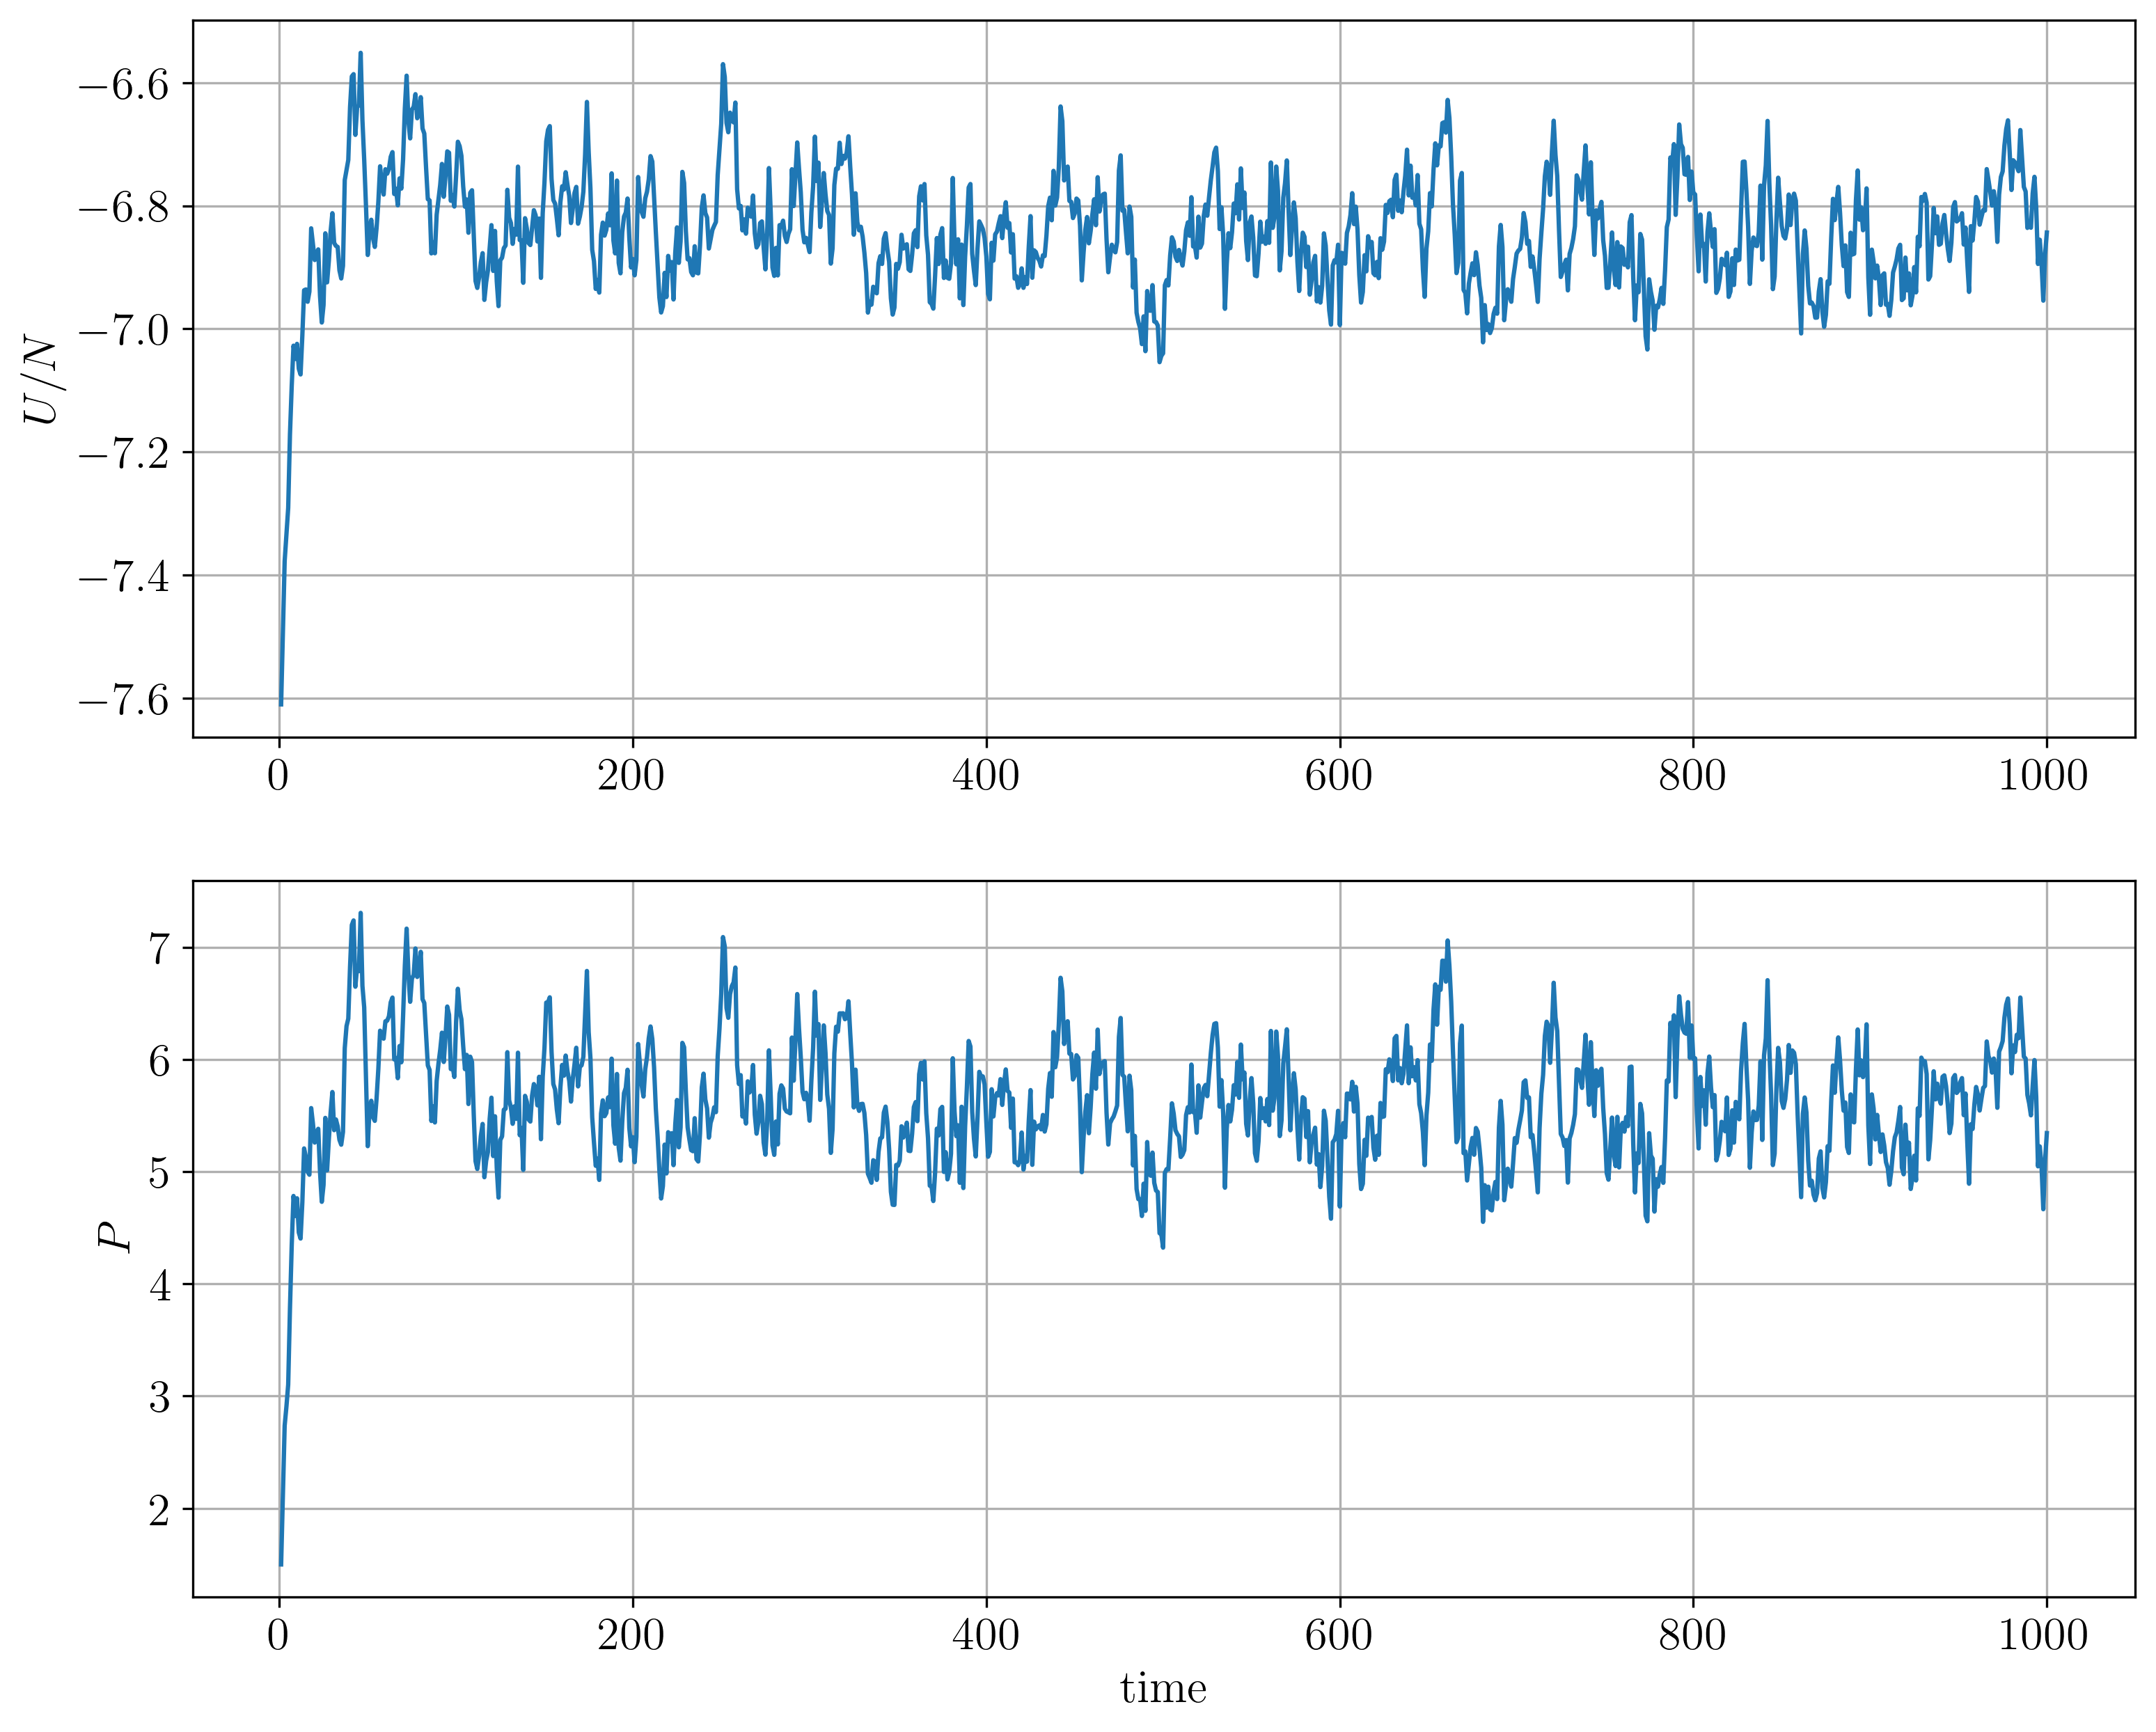

In [2]:
fig, axs = plt.subplots(2,1, figsize=(12,10), dpi=300)
u = np.loadtxt("./MDNVE_MCNVT/data/MC/equilibration_solid_output_epot.dat", usecols=1)
p = np.loadtxt("./MDNVE_MCNVT/data/MC/equilibration_solid_output_pres.dat", usecols=1)
x = np.arange(1,len(u)+1)
axs[0].plot(x,u)
axs[1].plot(x,p)
axs[0].set_ylabel("$U/N$")
axs[1].set_ylabel("$P$")
axs[1].set_xlabel("time")
axs[0].grid(True)
axs[1].grid(True)

plt.show()

**Autocorrelation functions**

In [3]:
u1 = np.loadtxt("./MDNVE_MCNVT/data/MC/solid_output_etot.dat", usecols=1, unpack=True)
p1 = np.loadtxt("./MDNVE_MCNVT/data/MC/solid_output_pres.dat", usecols=1, unpack=True)

In [4]:
def autocorrelation(OBS, tau):
    O1=0
    O2=0
    O3=0
    O4=0
    
    delta = len(OBS) - tau
    for t in range(delta):
        O1 += OBS[t]*OBS[t]
        O2 += OBS[t]*OBS[t+tau]
        O3 += OBS[t]
        O4 += OBS[t+tau]
    
    O5=O3
    for t in range(delta, len(OBS)):
        O1 += OBS[t]*OBS[t]
        O5 += OBS[t]
    
    O1 /= len(OBS)
    O2 /= delta
    O3 /= delta
    O4 /= delta
    O5 /= len(OBS)
    
    return (O2 - O3*O4)/(O1 - O5*O5)

In [5]:
time = np.arange(100)

In [6]:
E1 = np.array([])
P1 = np.array([])
for tau in time:
    E1 = np.append(E1, autocorrelation(u1, tau))
    P1 = np.append(P1, autocorrelation(p1, tau))

In [7]:
def exp(t, a, t_c):
    return a*np.exp(-t/t_c)

In [8]:
u1_opt, u1_cov = curve_fit(exp, time, E1)
p1_opt, p1_cov = curve_fit(exp, time, P1)
print("Fit of autocorrelation function with an exponential:")
print("Energy\t\t Pressure\n*************\t *************")
print(f"a   = {u1_opt[0]:.3f}\t a   = {p1_opt[0]:.3f}\nt_c = {u1_opt[1]:.3f}\t t_c = {p1_opt[1]:.3f}")

Fit of autocorrelation function with an exponential:
Energy		 Pressure
*************	 *************
a   = 0.889	 a   = 0.895
t_c = 8.444	 t_c = 7.856


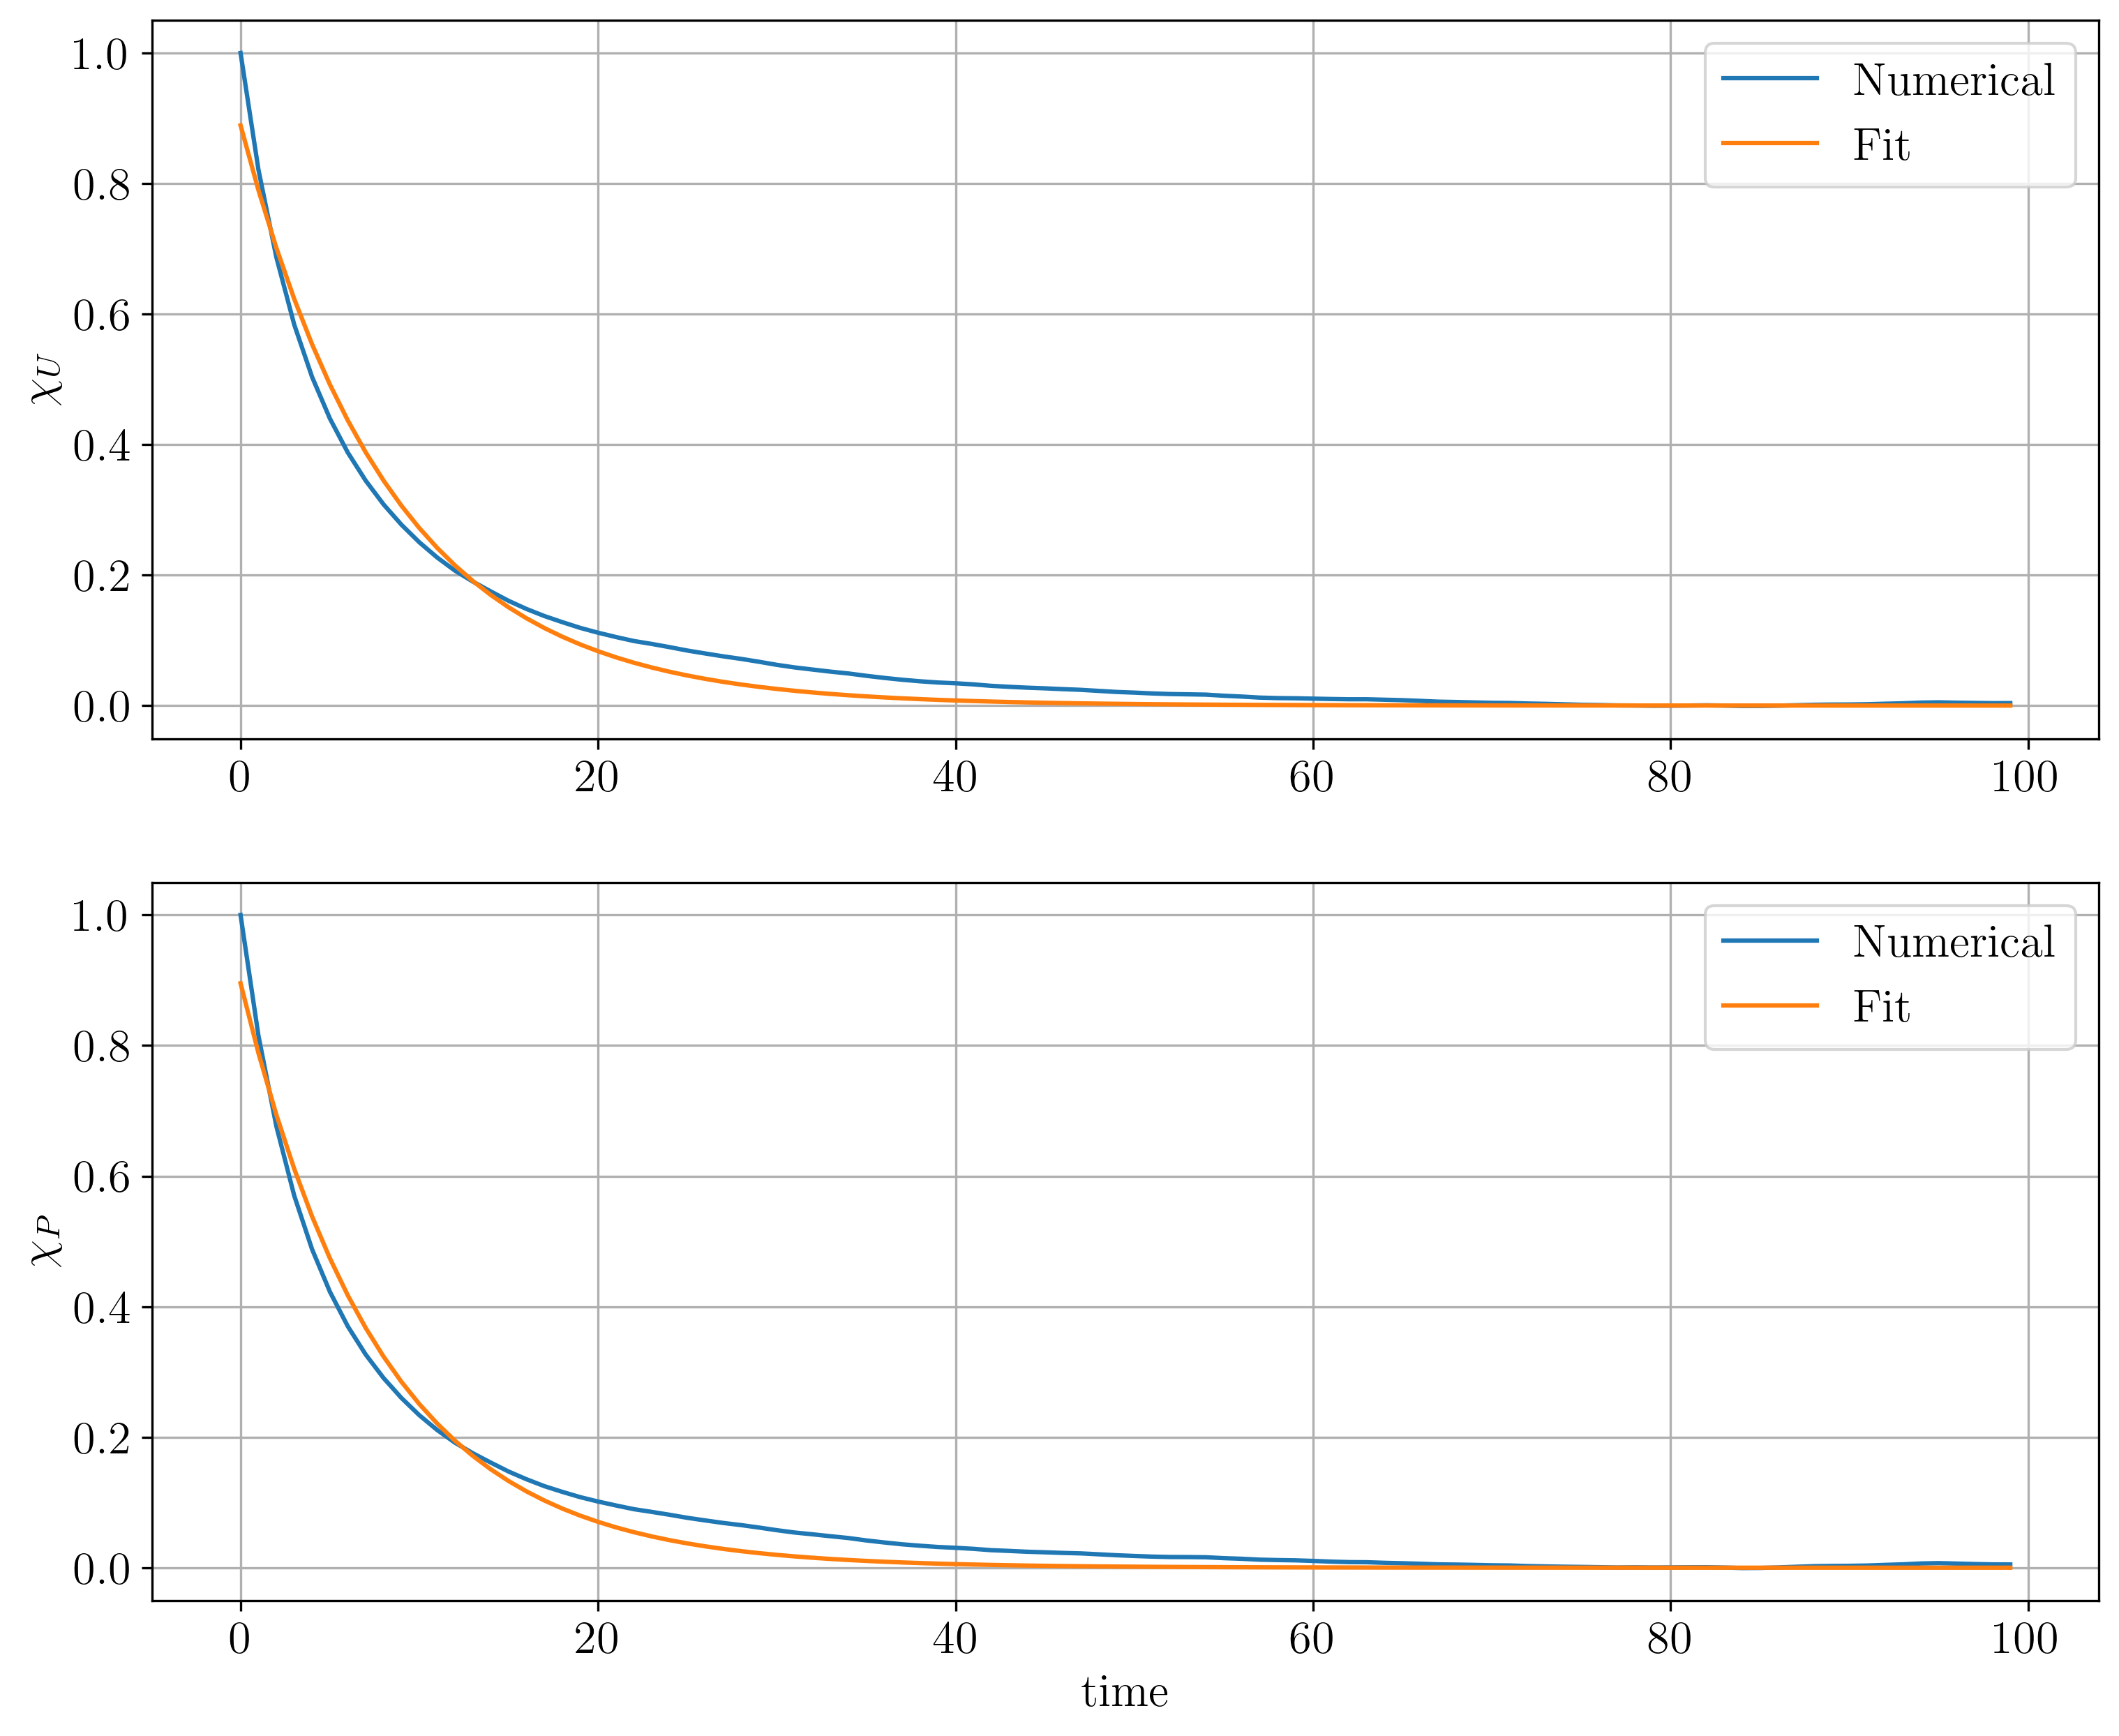

In [9]:
fig, axs = plt.subplots(2,1, figsize=(12,10), dpi=300)

axs[0].plot(time, E1, label="Numerical")
axs[0].plot(time, exp(time, u1_opt[0], u1_opt[1]), label="Fit")
axs[0].set_ylabel("$\chi_U$")
axs[1].set_ylabel("$\chi_P$")
axs[1].set_xlabel("time")
axs[1].plot(time, P1, label="Numerical")
axs[1].plot(time, exp(time, p1_opt[0], p1_opt[1]), label="Fit")


axs[0].legend()
axs[1].legend()
axs[0].grid(True)
axs[1].grid(True)
plt.show()

**Block size dependence of the statistical error**

In [10]:
L = np.array([1,2,5,10,20,50,100,200,500,1000,2000,5000]) # Throws per block
M = len(u1) # Throws
N = M/L # Blocks
err_u1 = np.array([]) # Errors as functions of L
err_p1 = np.array([])

for i in range(len(L)):
    blk_avgs_u = np.array([])
    blk_avgs_p = np.array([])
    for j in range(int(N[i])):
        blk_avgs_u = np.append(blk_avgs_u, u1[j*L[i]:(j+1)*L[i]].mean())
        blk_avgs_p = np.append(blk_avgs_p, p1[j*L[i]:(j+1)*L[i]].mean())
    u_avg = blk_avgs_u.mean()
    p_avg = blk_avgs_p.mean()
    tmp_u = blk_avgs_u*blk_avgs_u
    tmp_p = blk_avgs_p*blk_avgs_p
    u2_avg = tmp_u.mean()
    p2_avg = tmp_p.mean()
    err_u1 = np.append(err_u1, ((u2_avg - u_avg**2)/N[i])**.5)
    err_p1 = np.append(err_p1, ((p2_avg - p_avg**2)/N[i])**.5)

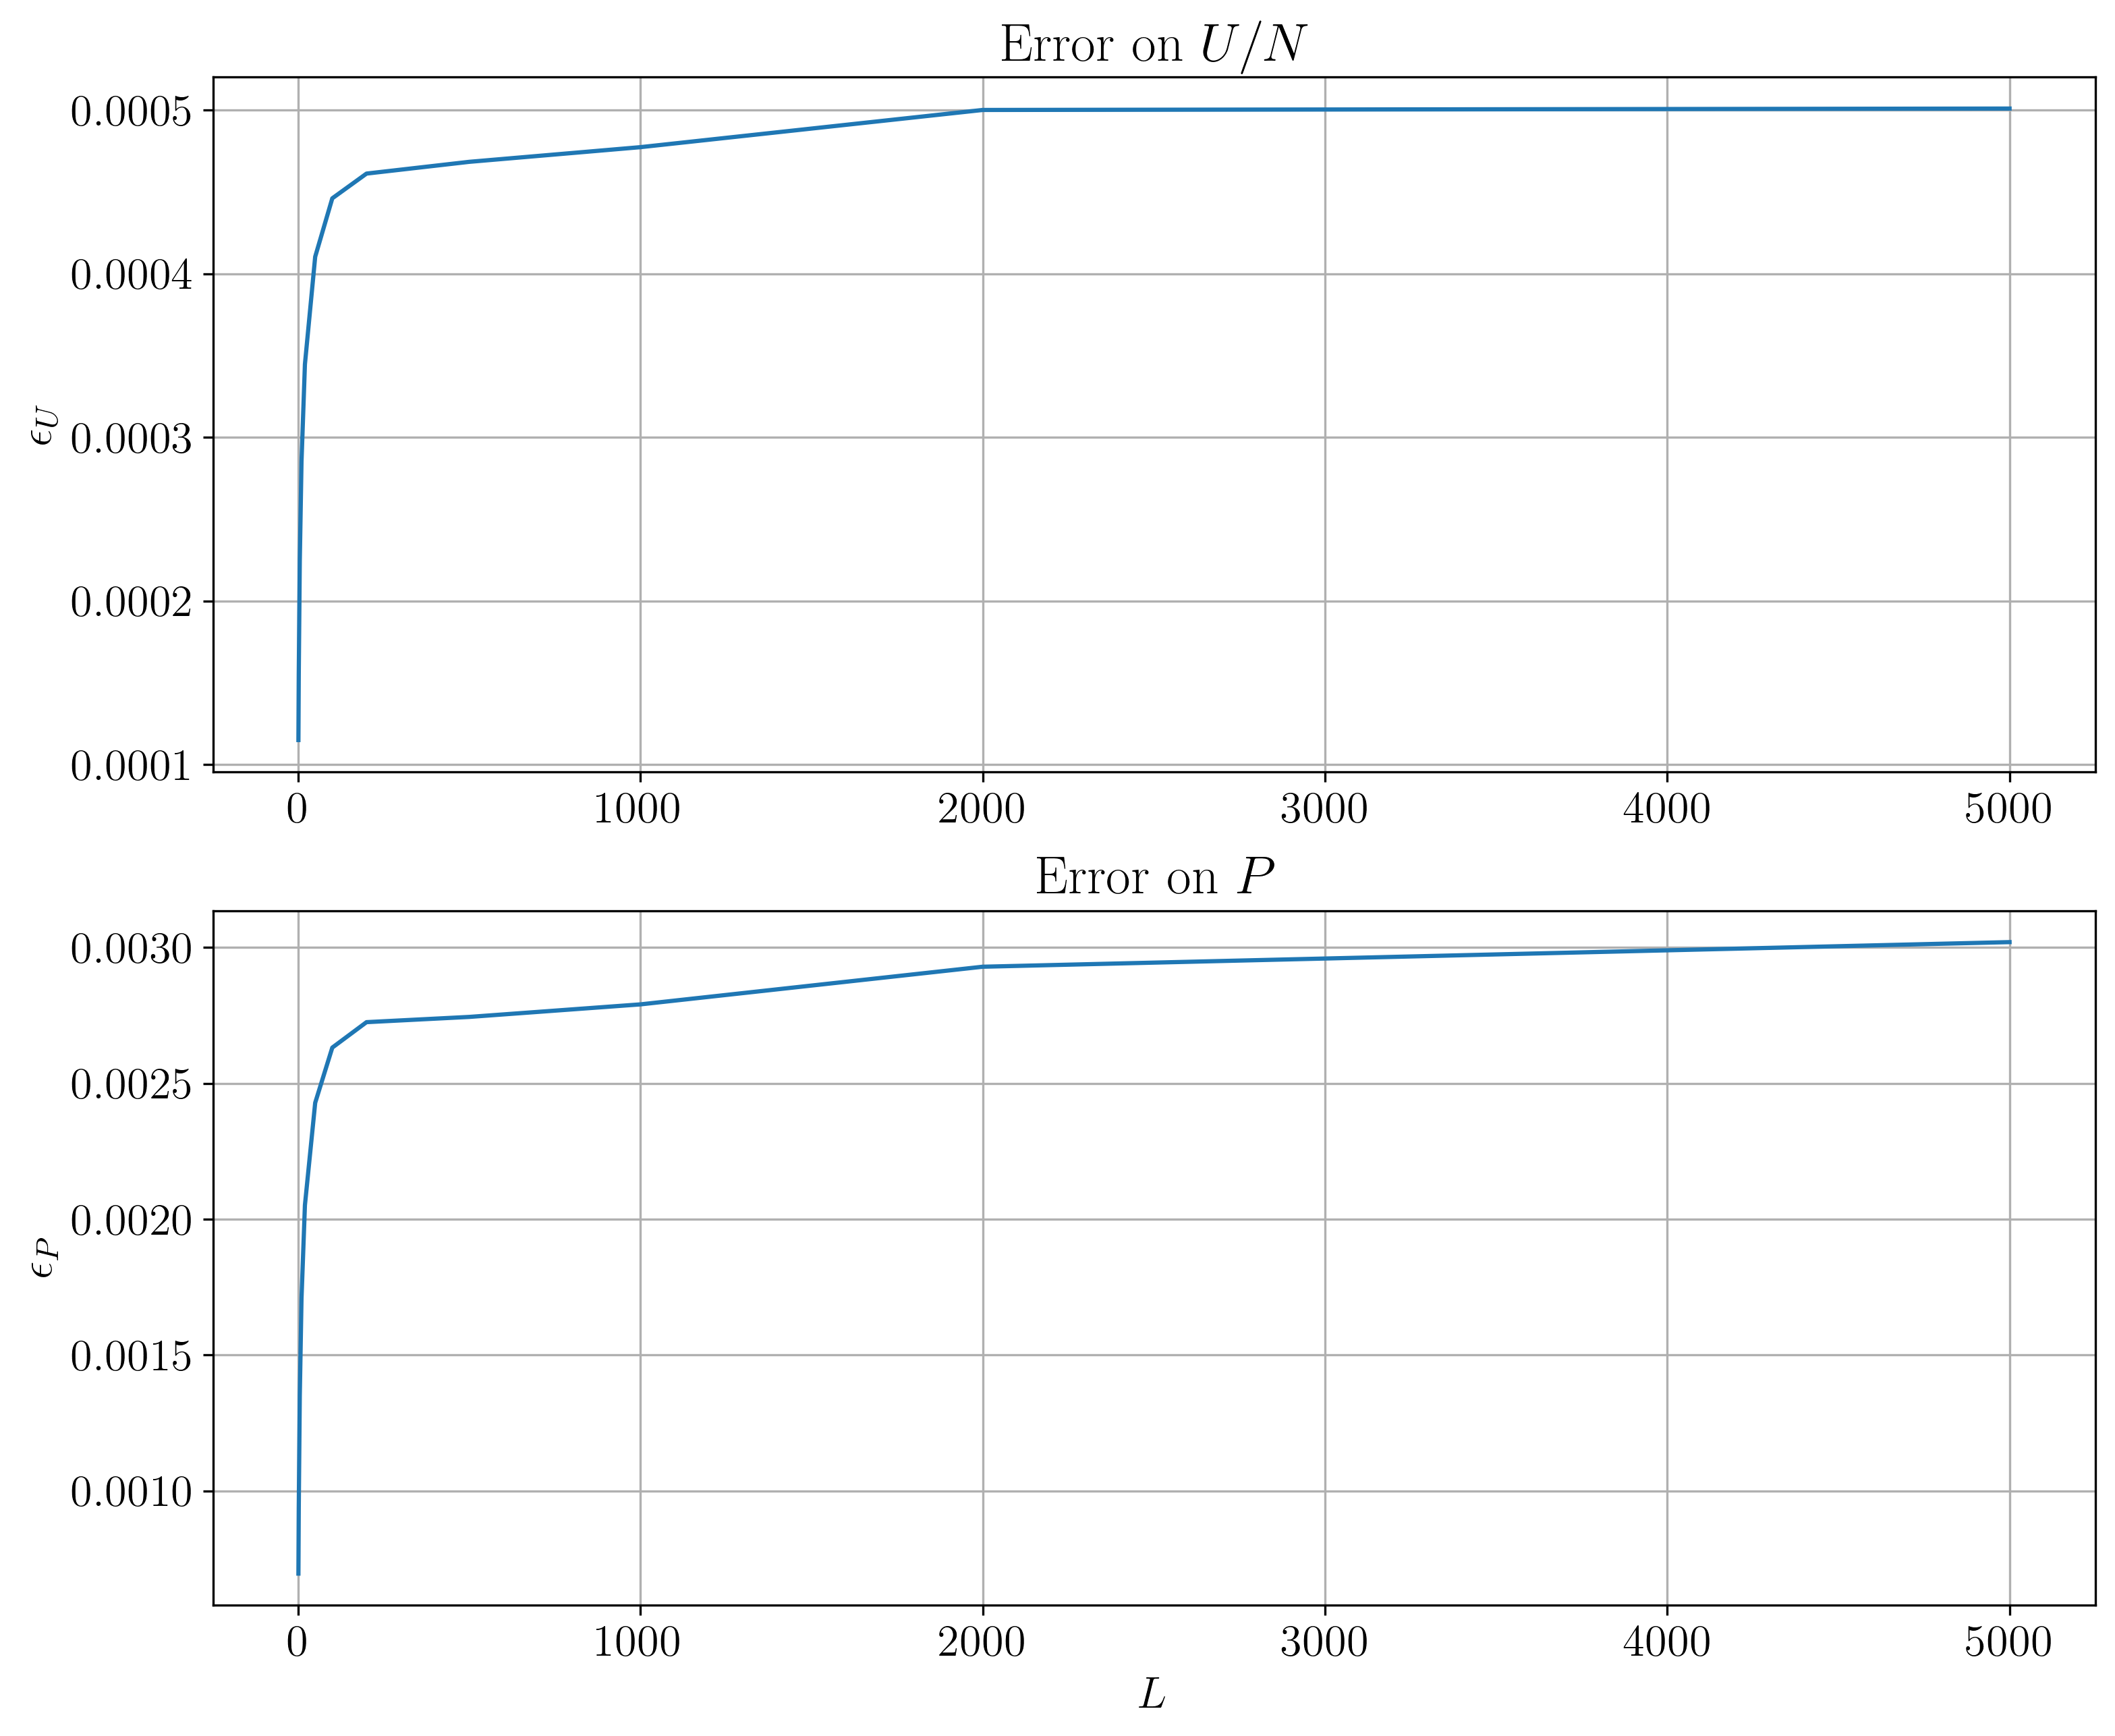

In [11]:
fig, axs = plt.subplots(2,1, figsize=(12,10), dpi=300)

axs[0].plot(L, err_u1)
axs[0].set_ylabel("$\epsilon_U$")
axs[0].set_title("Error on $U/N$")
axs[1].set_ylabel("$\epsilon_P$")
axs[1].set_xlabel("$L$")
axs[1].set_title("Error on $P$")
axs[1].plot(L, err_p1)

axs[0].grid(True)
axs[1].grid(True)
plt.show()

If, instead of looking at the standard error of the mean, we look at the standard deviation of the distribution of the block variables (the averages of the values of the observable inside a grouped in a single block), we see the following behaviour:

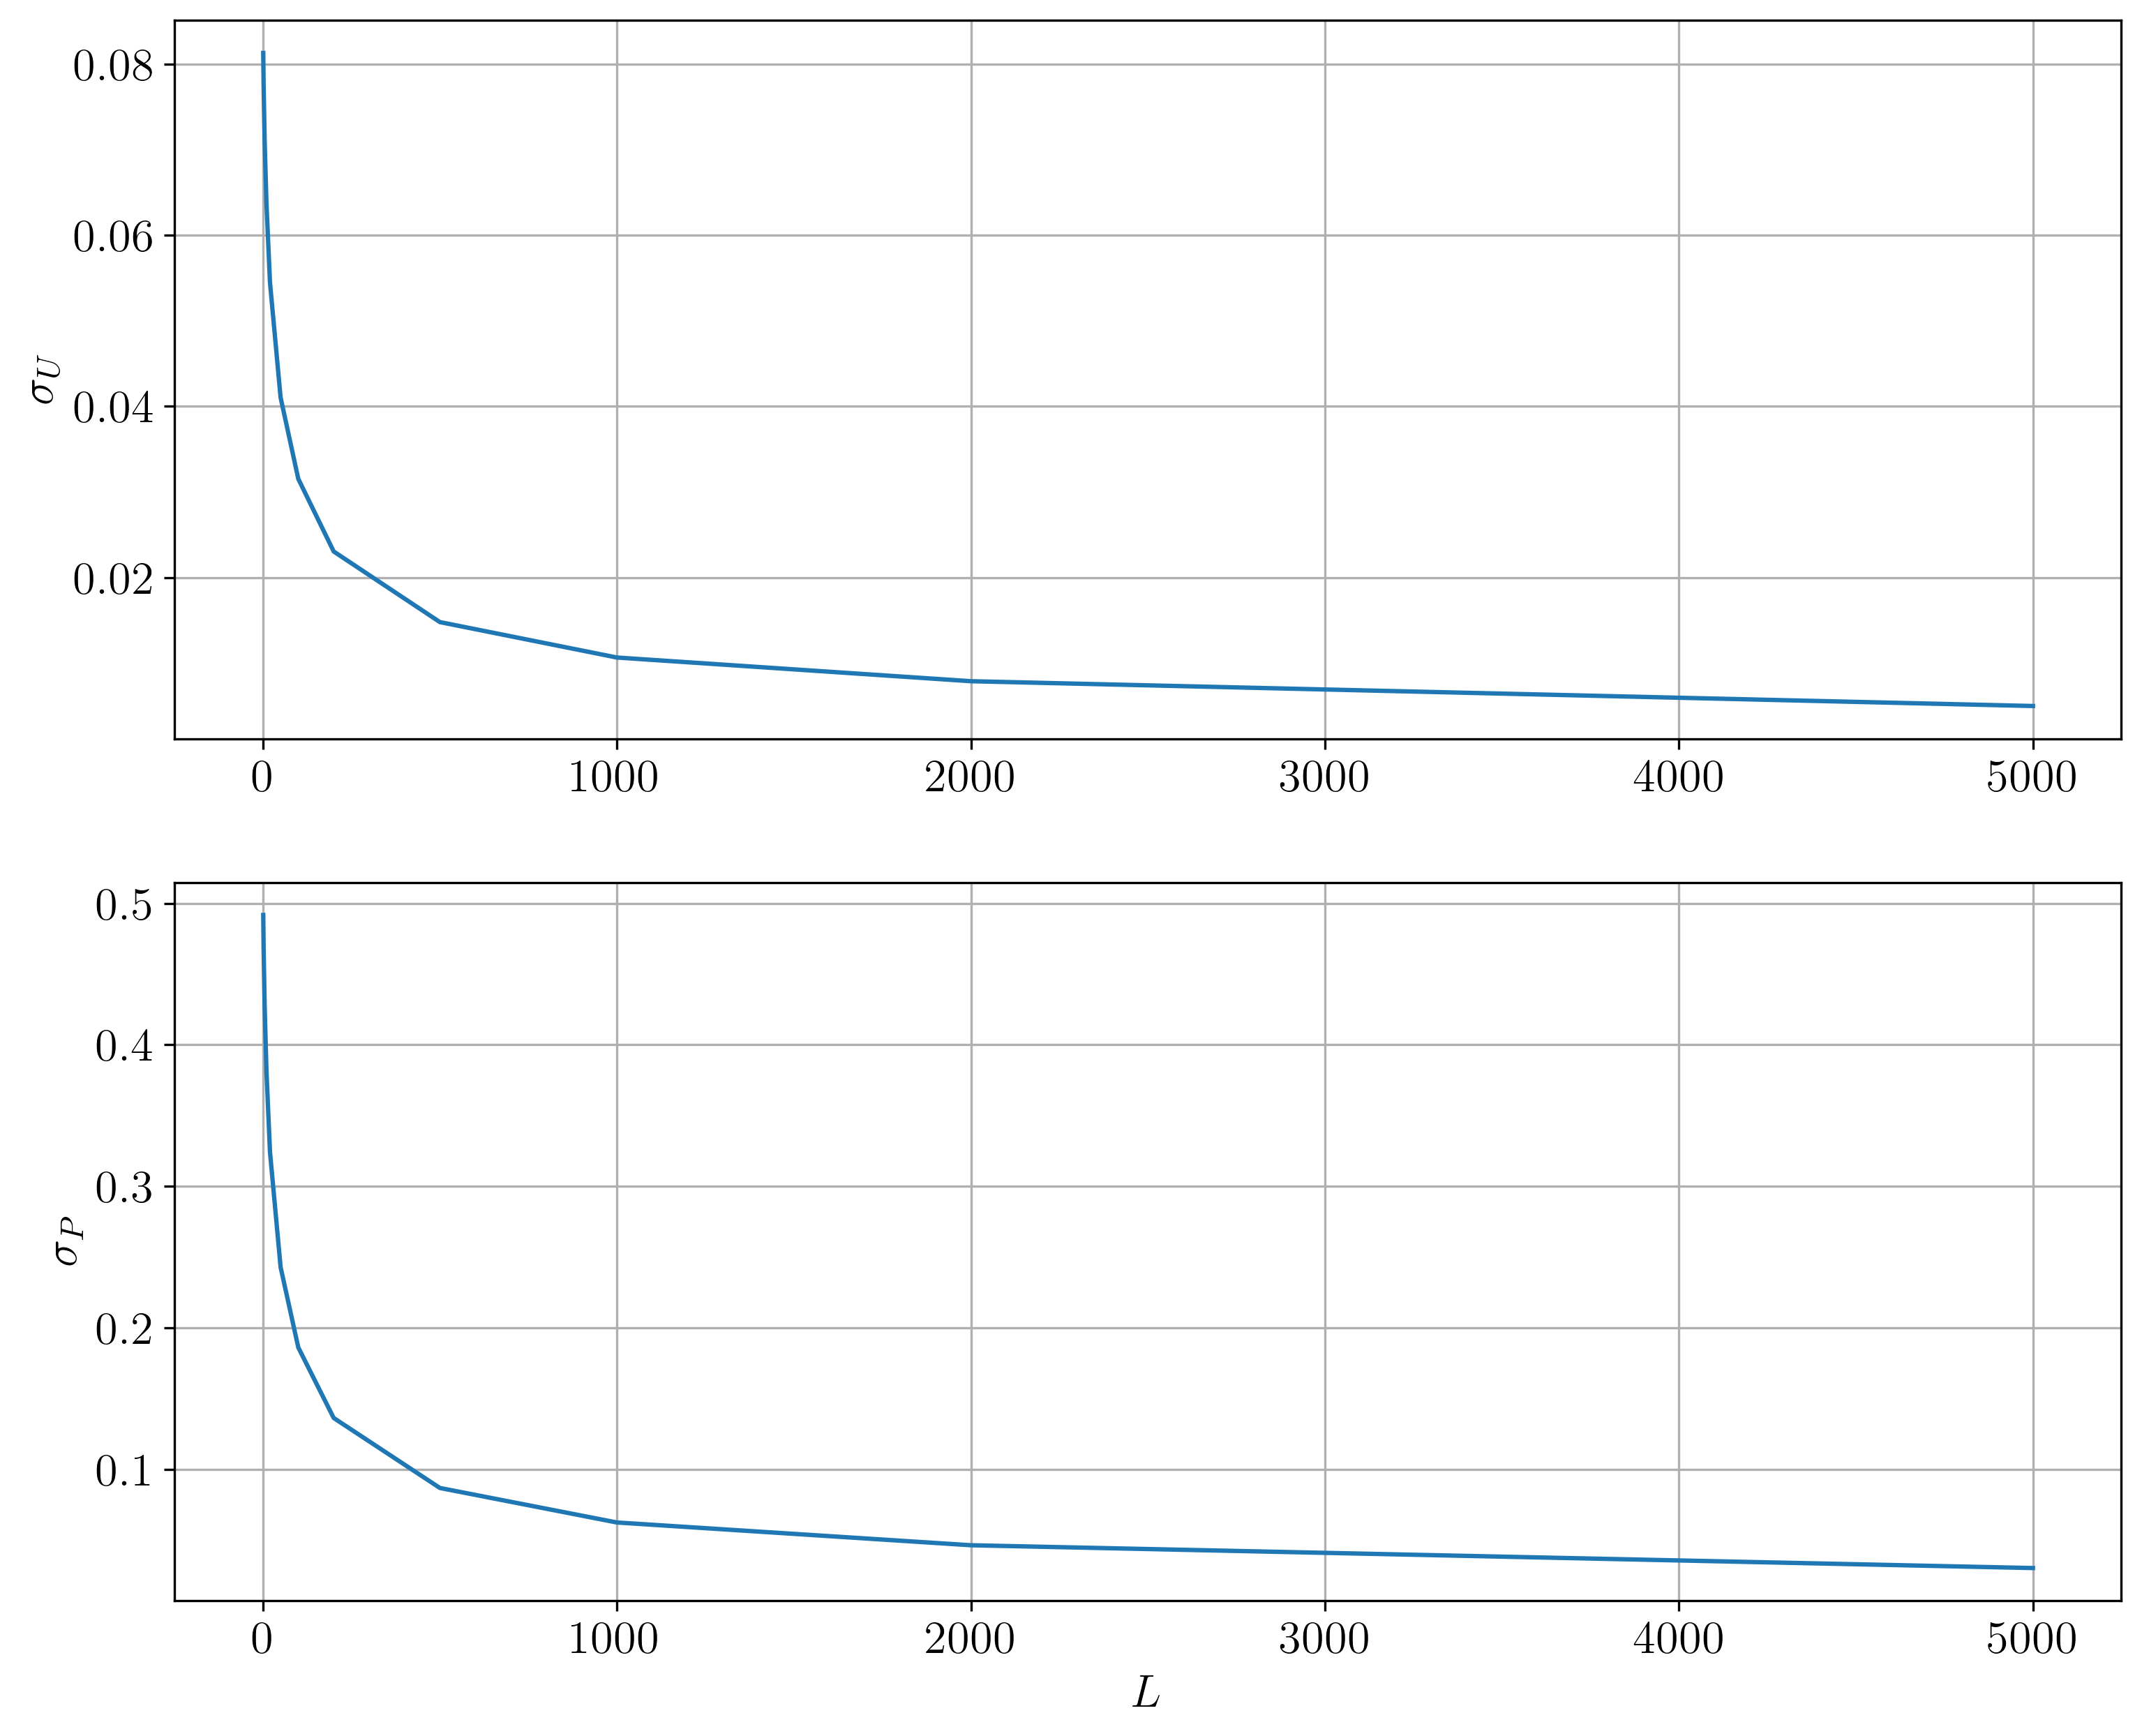

In [12]:
fig, axs = plt.subplots(2,1, figsize=(12,10), dpi=300)

axs[0].plot(L, err_u1*np.sqrt(N))
axs[0].set_ylabel("$\sigma_U$")
axs[1].set_ylabel("$\sigma_P$")
axs[1].set_xlabel("$L$")
axs[1].plot(L, err_p1*np.sqrt(N))

axs[0].grid(True)
axs[1].grid(True)
plt.show()

After roughly 2000 MC steps per block the distribution of the block variables becomes narrow and it does not get much more narrow by increasing $L$.

### <span style=color:darkblue> LIQUID </span>

I equilibrated starting from a fcc configuration.
I run the simulation with transition step 0.20 for 5e+5 MC steps.

**Equilibration**

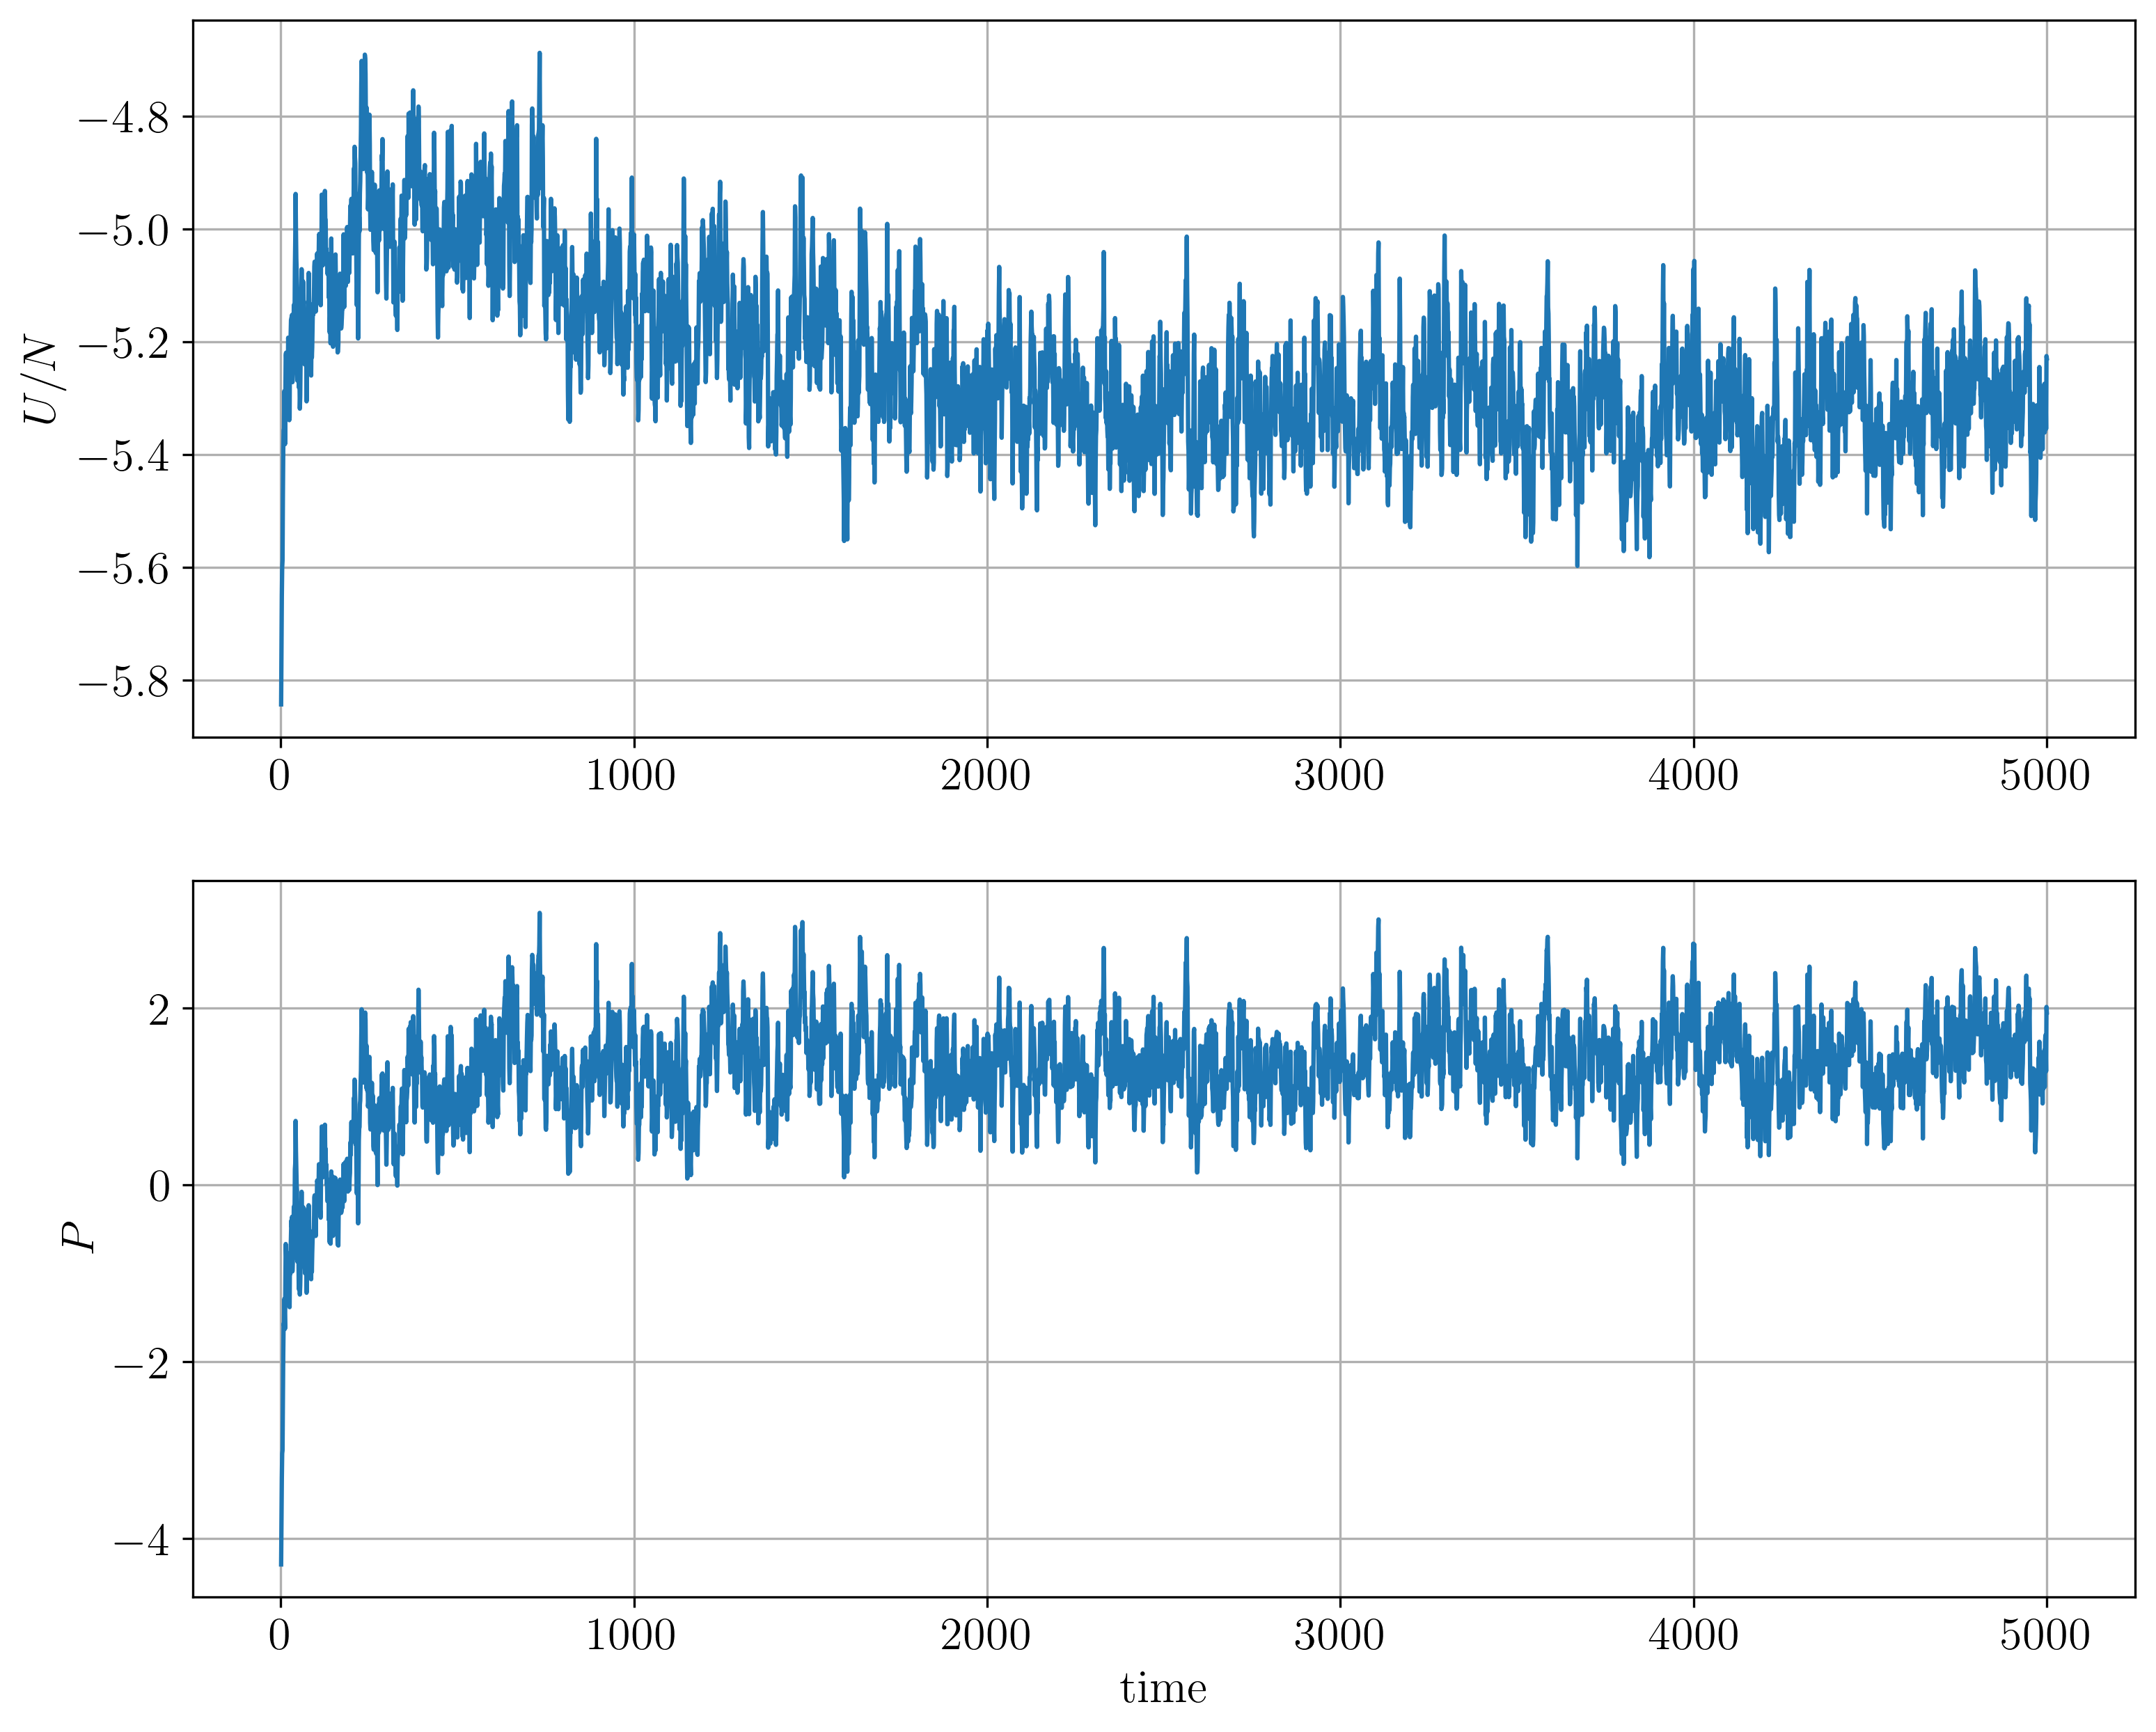

In [13]:
fig, axs = plt.subplots(2,1, figsize=(12,10), dpi=300)
u = np.loadtxt("./MDNVE_MCNVT/data/MC/equilibration_liquid_output_epot.dat", usecols=1)
p = np.loadtxt("./MDNVE_MCNVT/data/MC/equilibration_liquid_output_pres.dat", usecols=1)
x = np.arange(1,len(u)+1)
axs[0].plot(x,u)
axs[1].plot(x,p)
axs[0].set_ylabel("$U/N$")
axs[1].set_ylabel("$P$")
axs[1].set_xlabel("time")
axs[0].grid(True)
axs[1].grid(True)

plt.show()

**Autocorrelation functions**

In [14]:
u2 = np.loadtxt("./MDNVE_MCNVT/data/MC/liquid_output_etot.dat", usecols=1, unpack=True)
p2 = np.loadtxt("./MDNVE_MCNVT/data/MC/liquid_output_pres.dat", usecols=1, unpack=True)

In [15]:
E2 = np.array([])
P2 = np.array([])
for tau in time:
    E2 = np.append(E2, autocorrelation(u2, tau))
    P2 = np.append(P2, autocorrelation(p2, tau))

In [16]:
u2_opt, u2_cov = curve_fit(exp, time, E2)
p2_opt, p2_cov = curve_fit(exp, time, P2)
print("Fit of autocorrelation function with an exponential:")
print("Energy\t\t Pressure\n*************\t *************")
print(f"a   = {u2_opt[0]:.3f}\t a   = {p2_opt[0]:.3f}\nt_c = {u2_opt[1]:.3f}\t t_c = {p2_opt[1]:.3f}")

Fit of autocorrelation function with an exponential:
Energy		 Pressure
*************	 *************
a   = 0.590	 a   = 0.666
t_c = 27.980	 t_c = 23.106


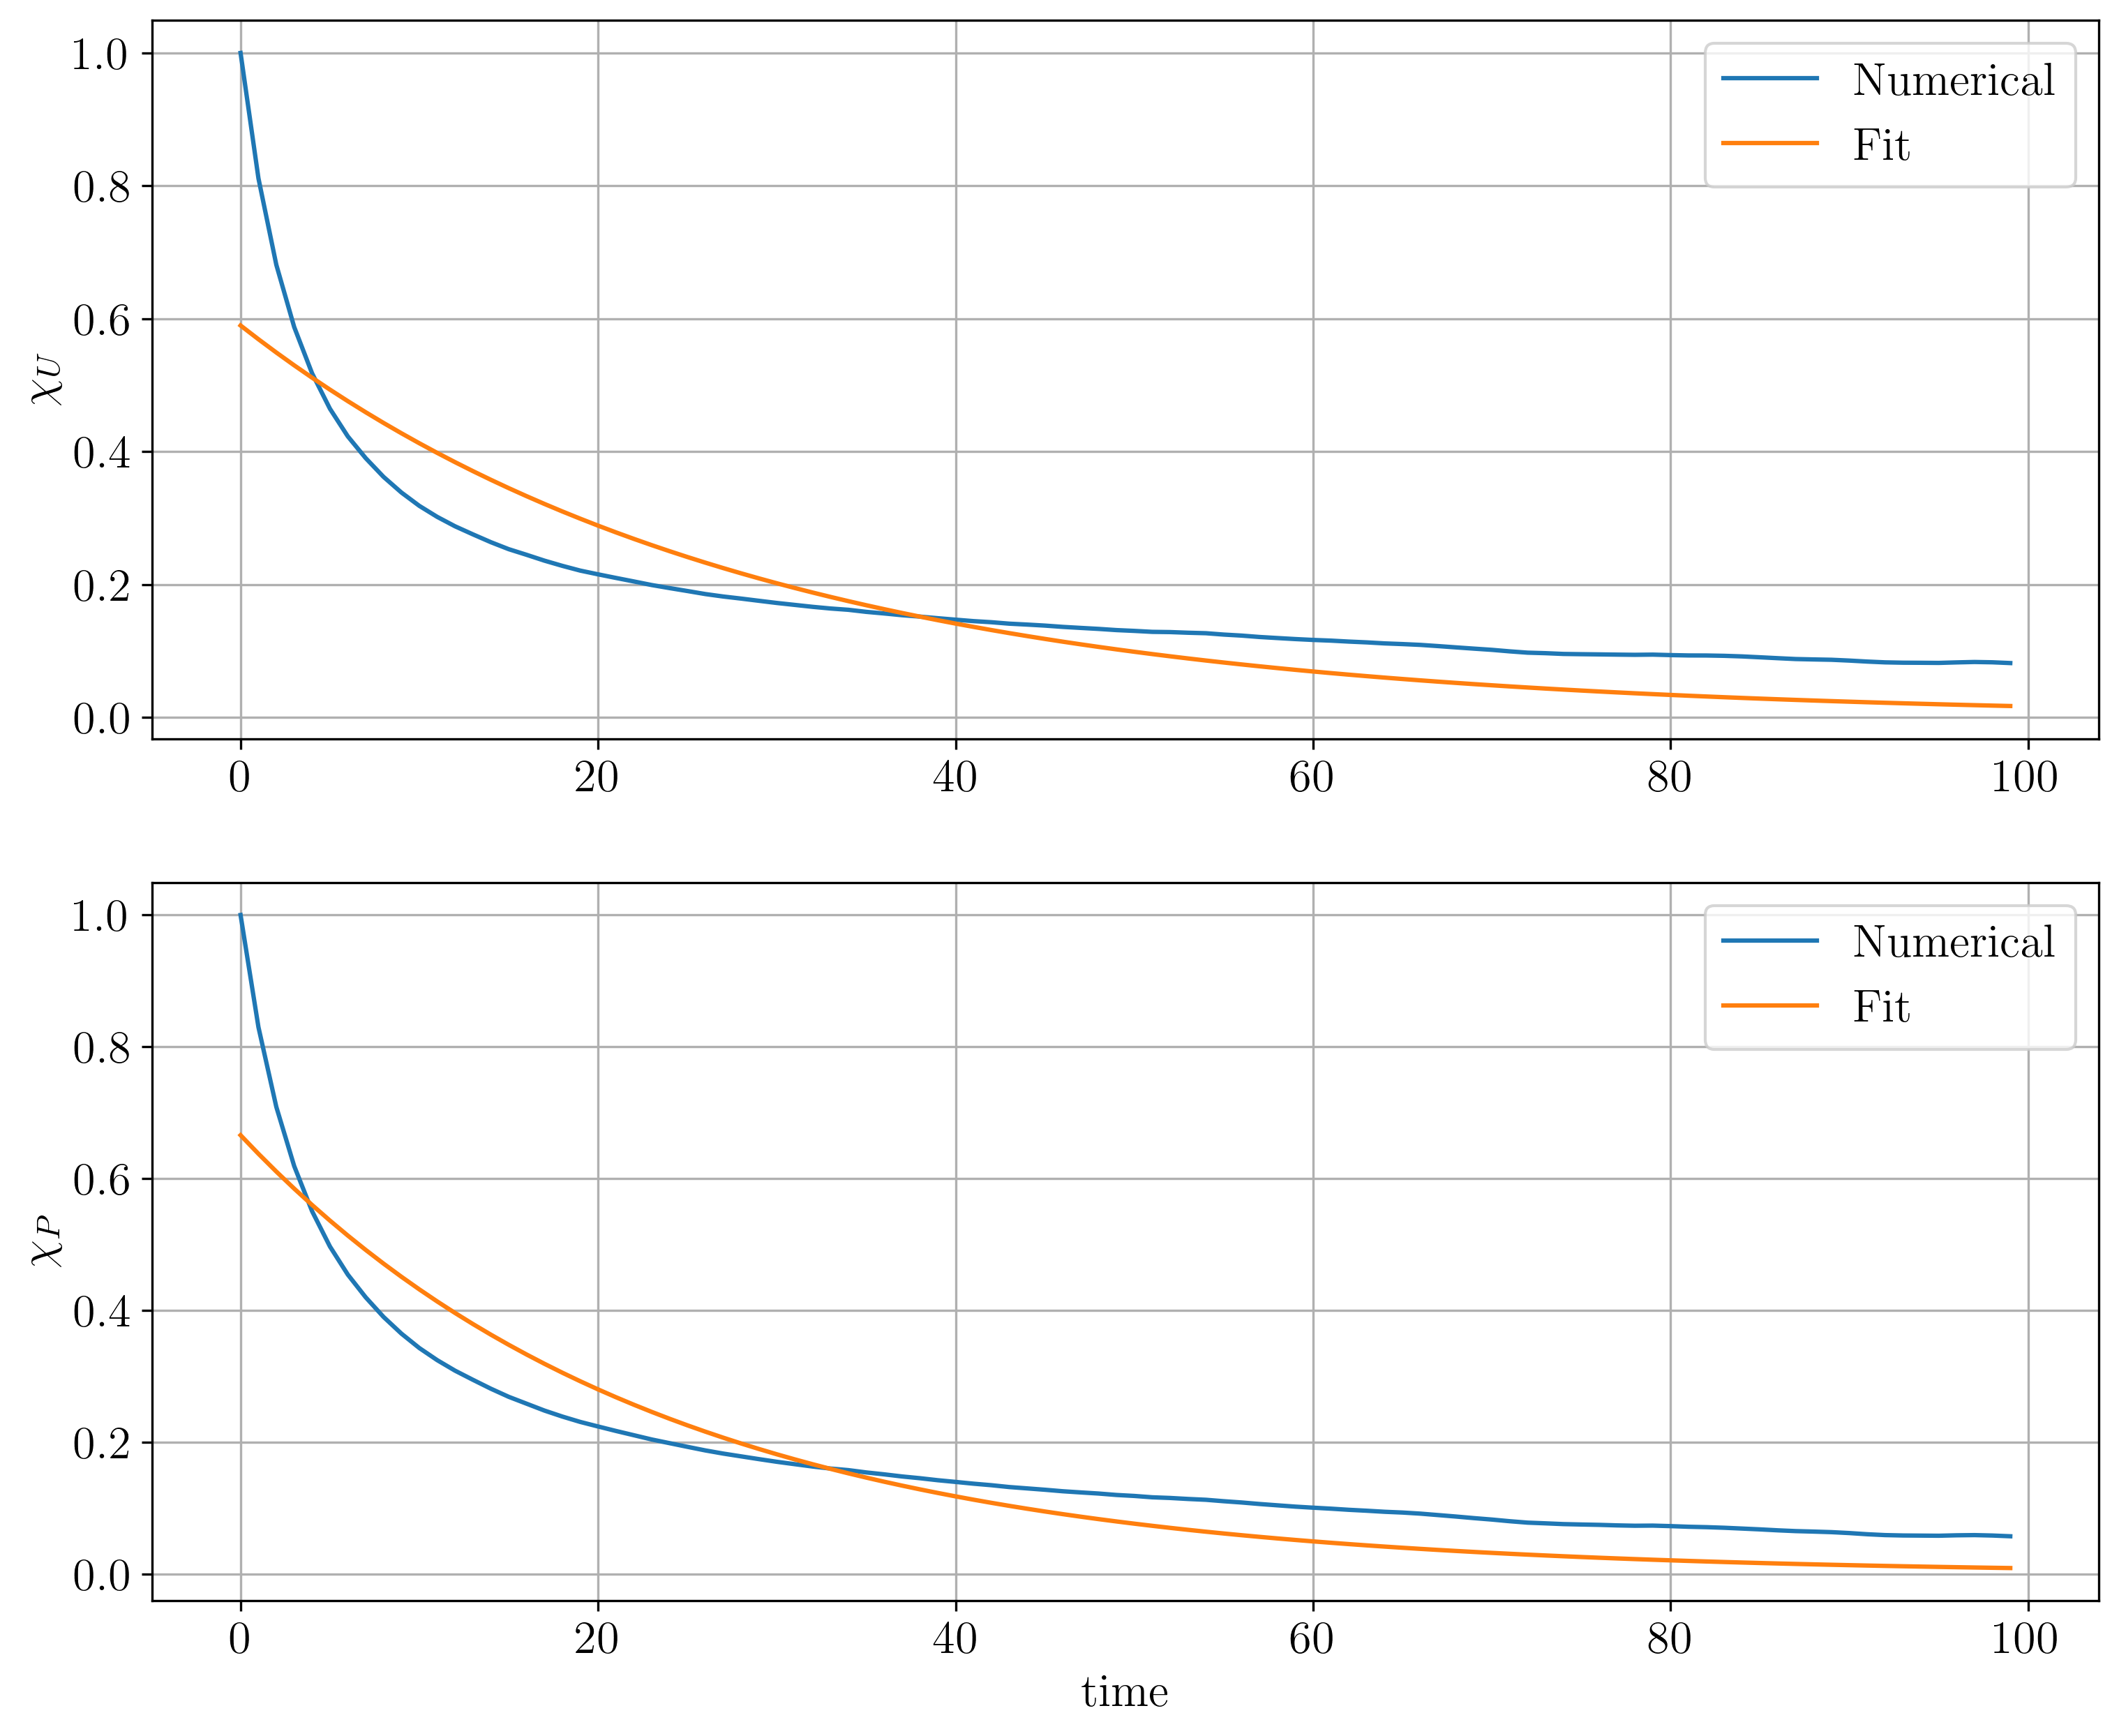

In [17]:
fig, axs = plt.subplots(2,1, figsize=(12,10), dpi=300)

axs[0].plot(time, E2, label="Numerical")
axs[0].plot(time, exp(time, u2_opt[0], u2_opt[1]), label="Fit")
axs[0].set_ylabel("$\chi_U$")
axs[1].set_ylabel("$\chi_P$")
axs[1].set_xlabel("time")
axs[1].plot(time, P2, label="Numerical")
axs[1].plot(time, exp(time, p2_opt[0], p2_opt[1]), label="Fit")


axs[0].legend()
axs[1].legend()
axs[0].grid(True)
axs[1].grid(True)
plt.show()

**Block size dependence of the statistical error**

In [18]:
L = np.array([1,2,5,10,20,50,100,200,500,1000,2000,5000]) # Throws per block
M = len(u2) # Throws
N = M/L # Blocks
err_u2 = np.array([]) # Errors as functions of L
err_p2 = np.array([])

for i in range(len(L)):
    blk_avgs_u = np.array([])
    blk_avgs_p = np.array([])
    for j in range(int(N[i])):
        blk_avgs_u = np.append(blk_avgs_u, u2[j*L[i]:(j+1)*L[i]].mean())
        blk_avgs_p = np.append(blk_avgs_p, p2[j*L[i]:(j+1)*L[i]].mean())
    u_avg = blk_avgs_u.mean()
    p_avg = blk_avgs_p.mean()
    tmp_u = blk_avgs_u*blk_avgs_u
    tmp_p = blk_avgs_p*blk_avgs_p
    u2_avg = tmp_u.mean()
    p2_avg = tmp_p.mean()
    err_u2 = np.append(err_u2, ((u2_avg - u_avg**2)/N[i])**.5)
    err_p2 = np.append(err_p2, ((p2_avg - p_avg**2)/N[i])**.5)

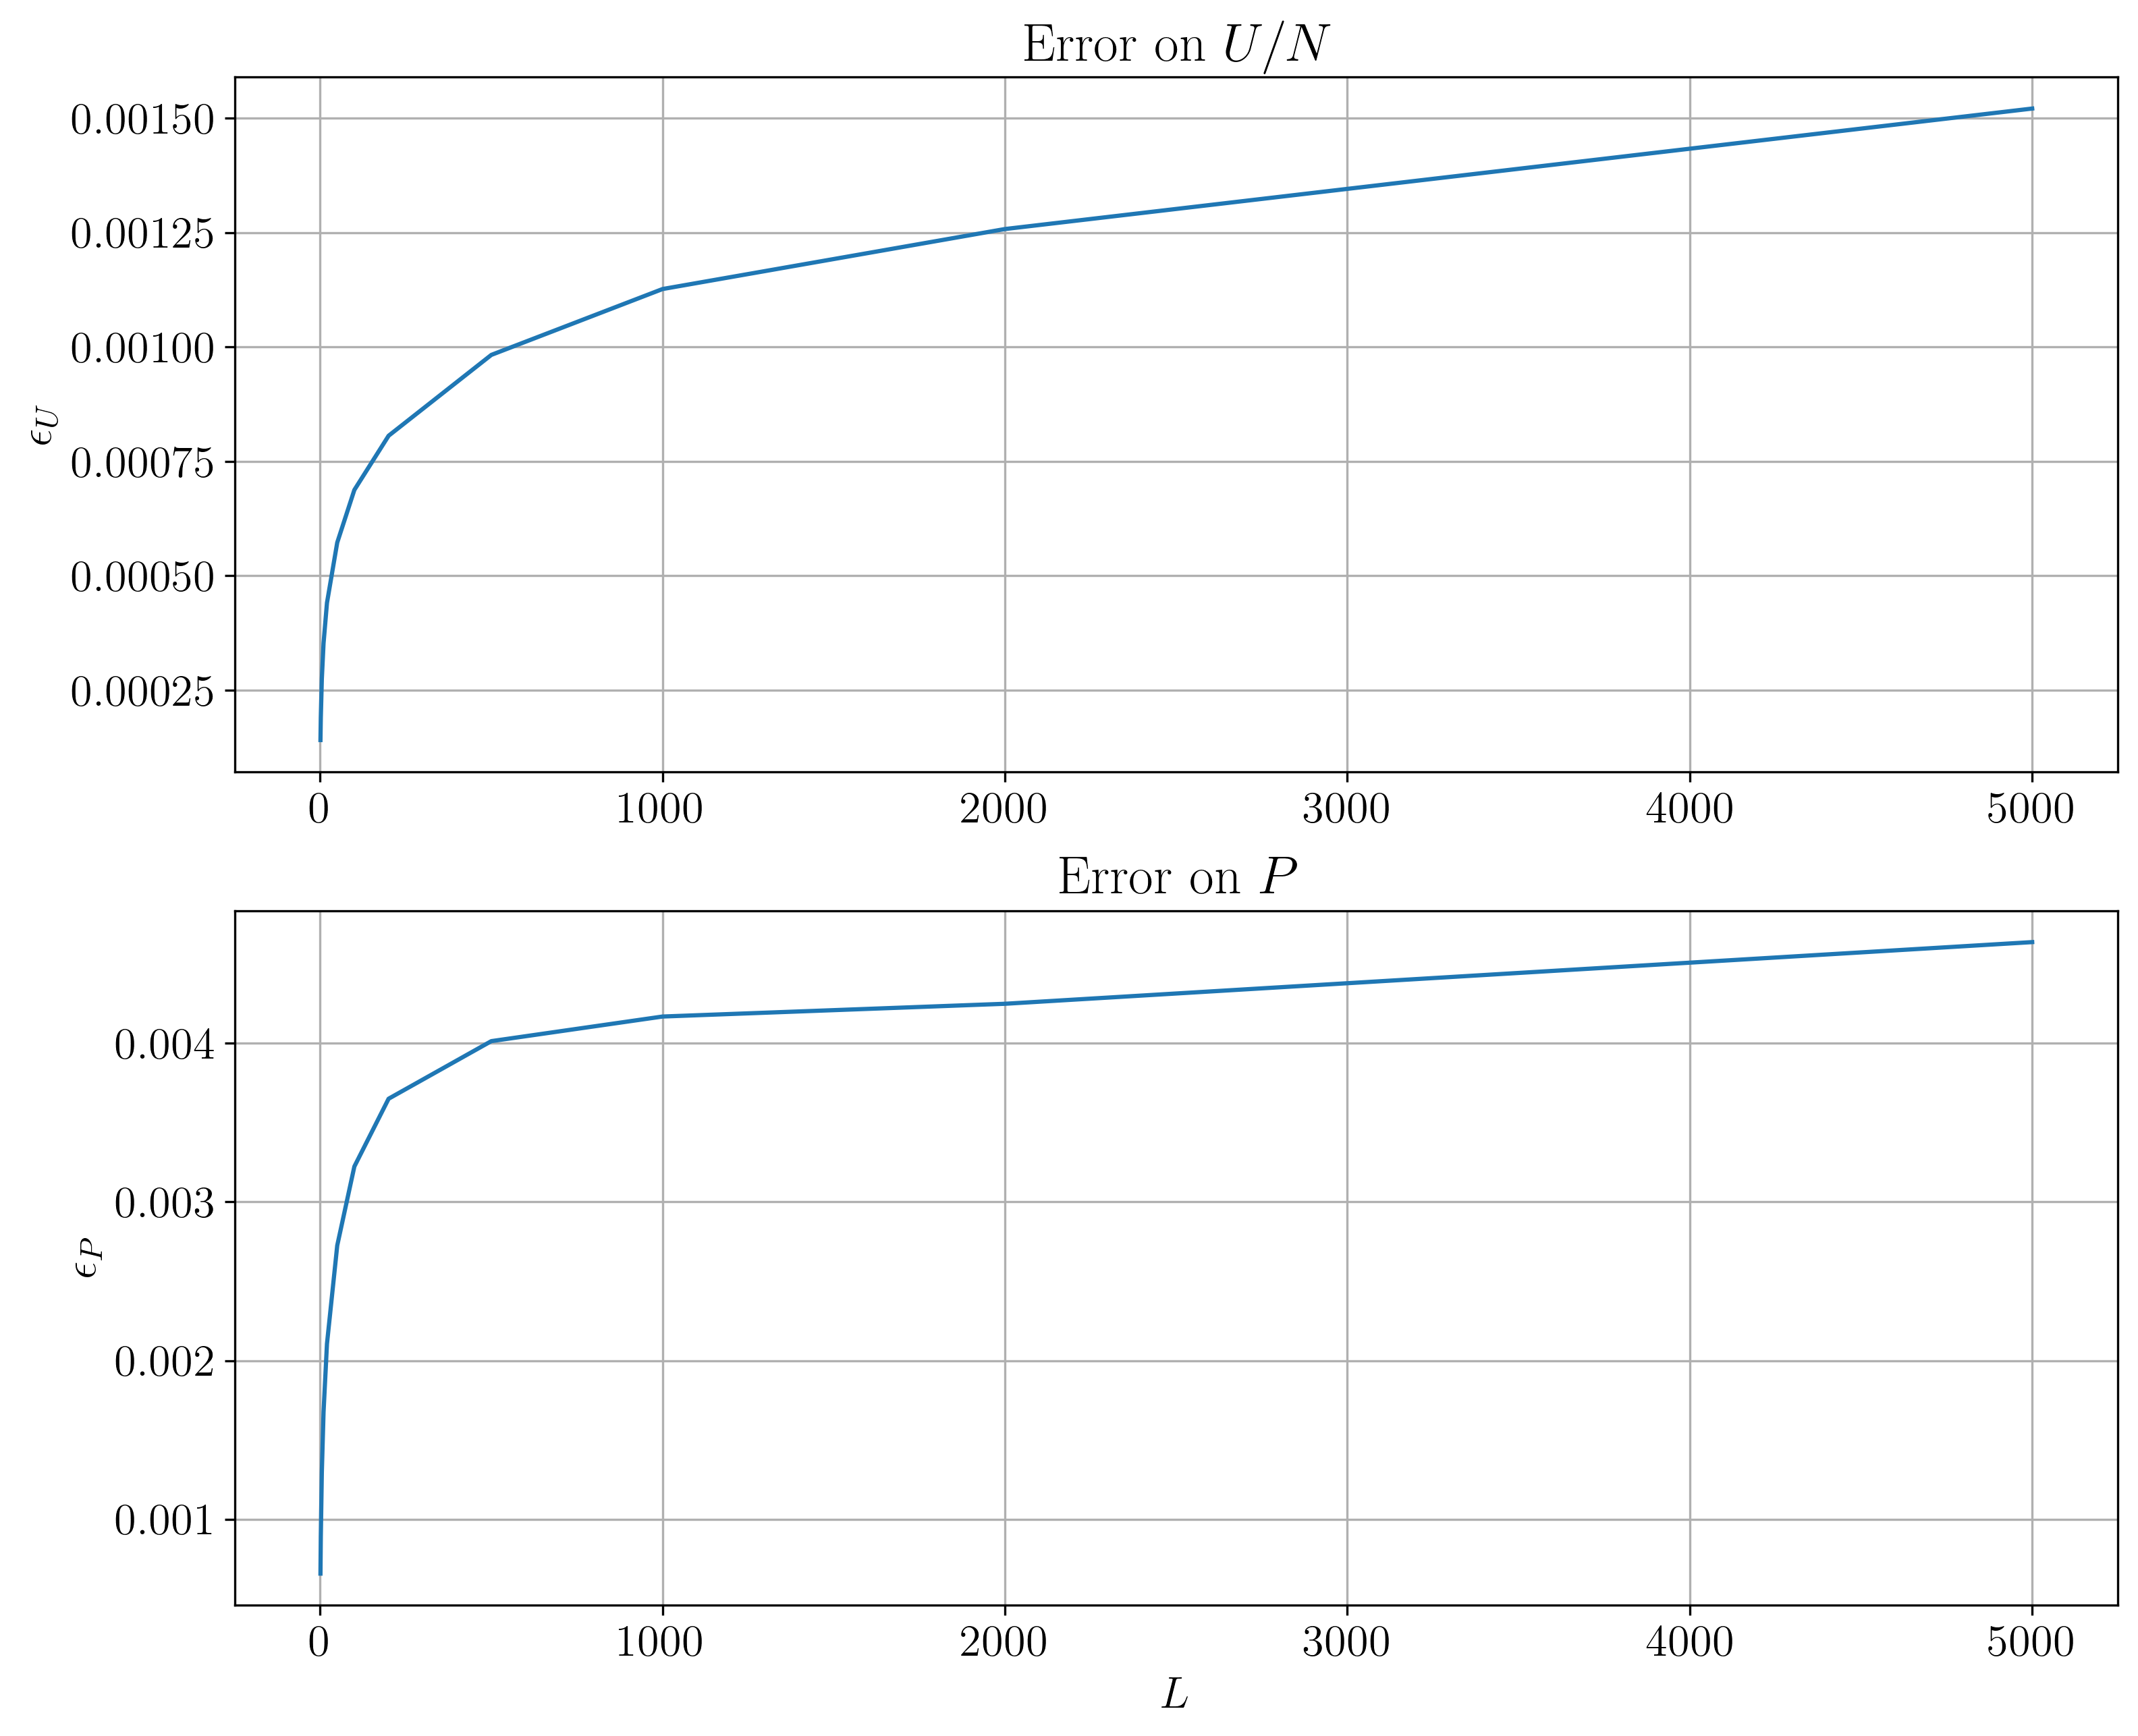

In [19]:
fig, axs = plt.subplots(2,1, figsize=(12,10), dpi=300)

axs[0].plot(L, err_u2)
axs[0].set_ylabel("$\epsilon_U$")
axs[0].set_title("Error on $U/N$")
axs[1].set_ylabel("$\epsilon_P$")
axs[1].set_xlabel("$L$")
axs[1].set_title("Error on $P$")
axs[1].plot(L, err_p2)

axs[0].grid(True)
axs[1].grid(True)
plt.show()

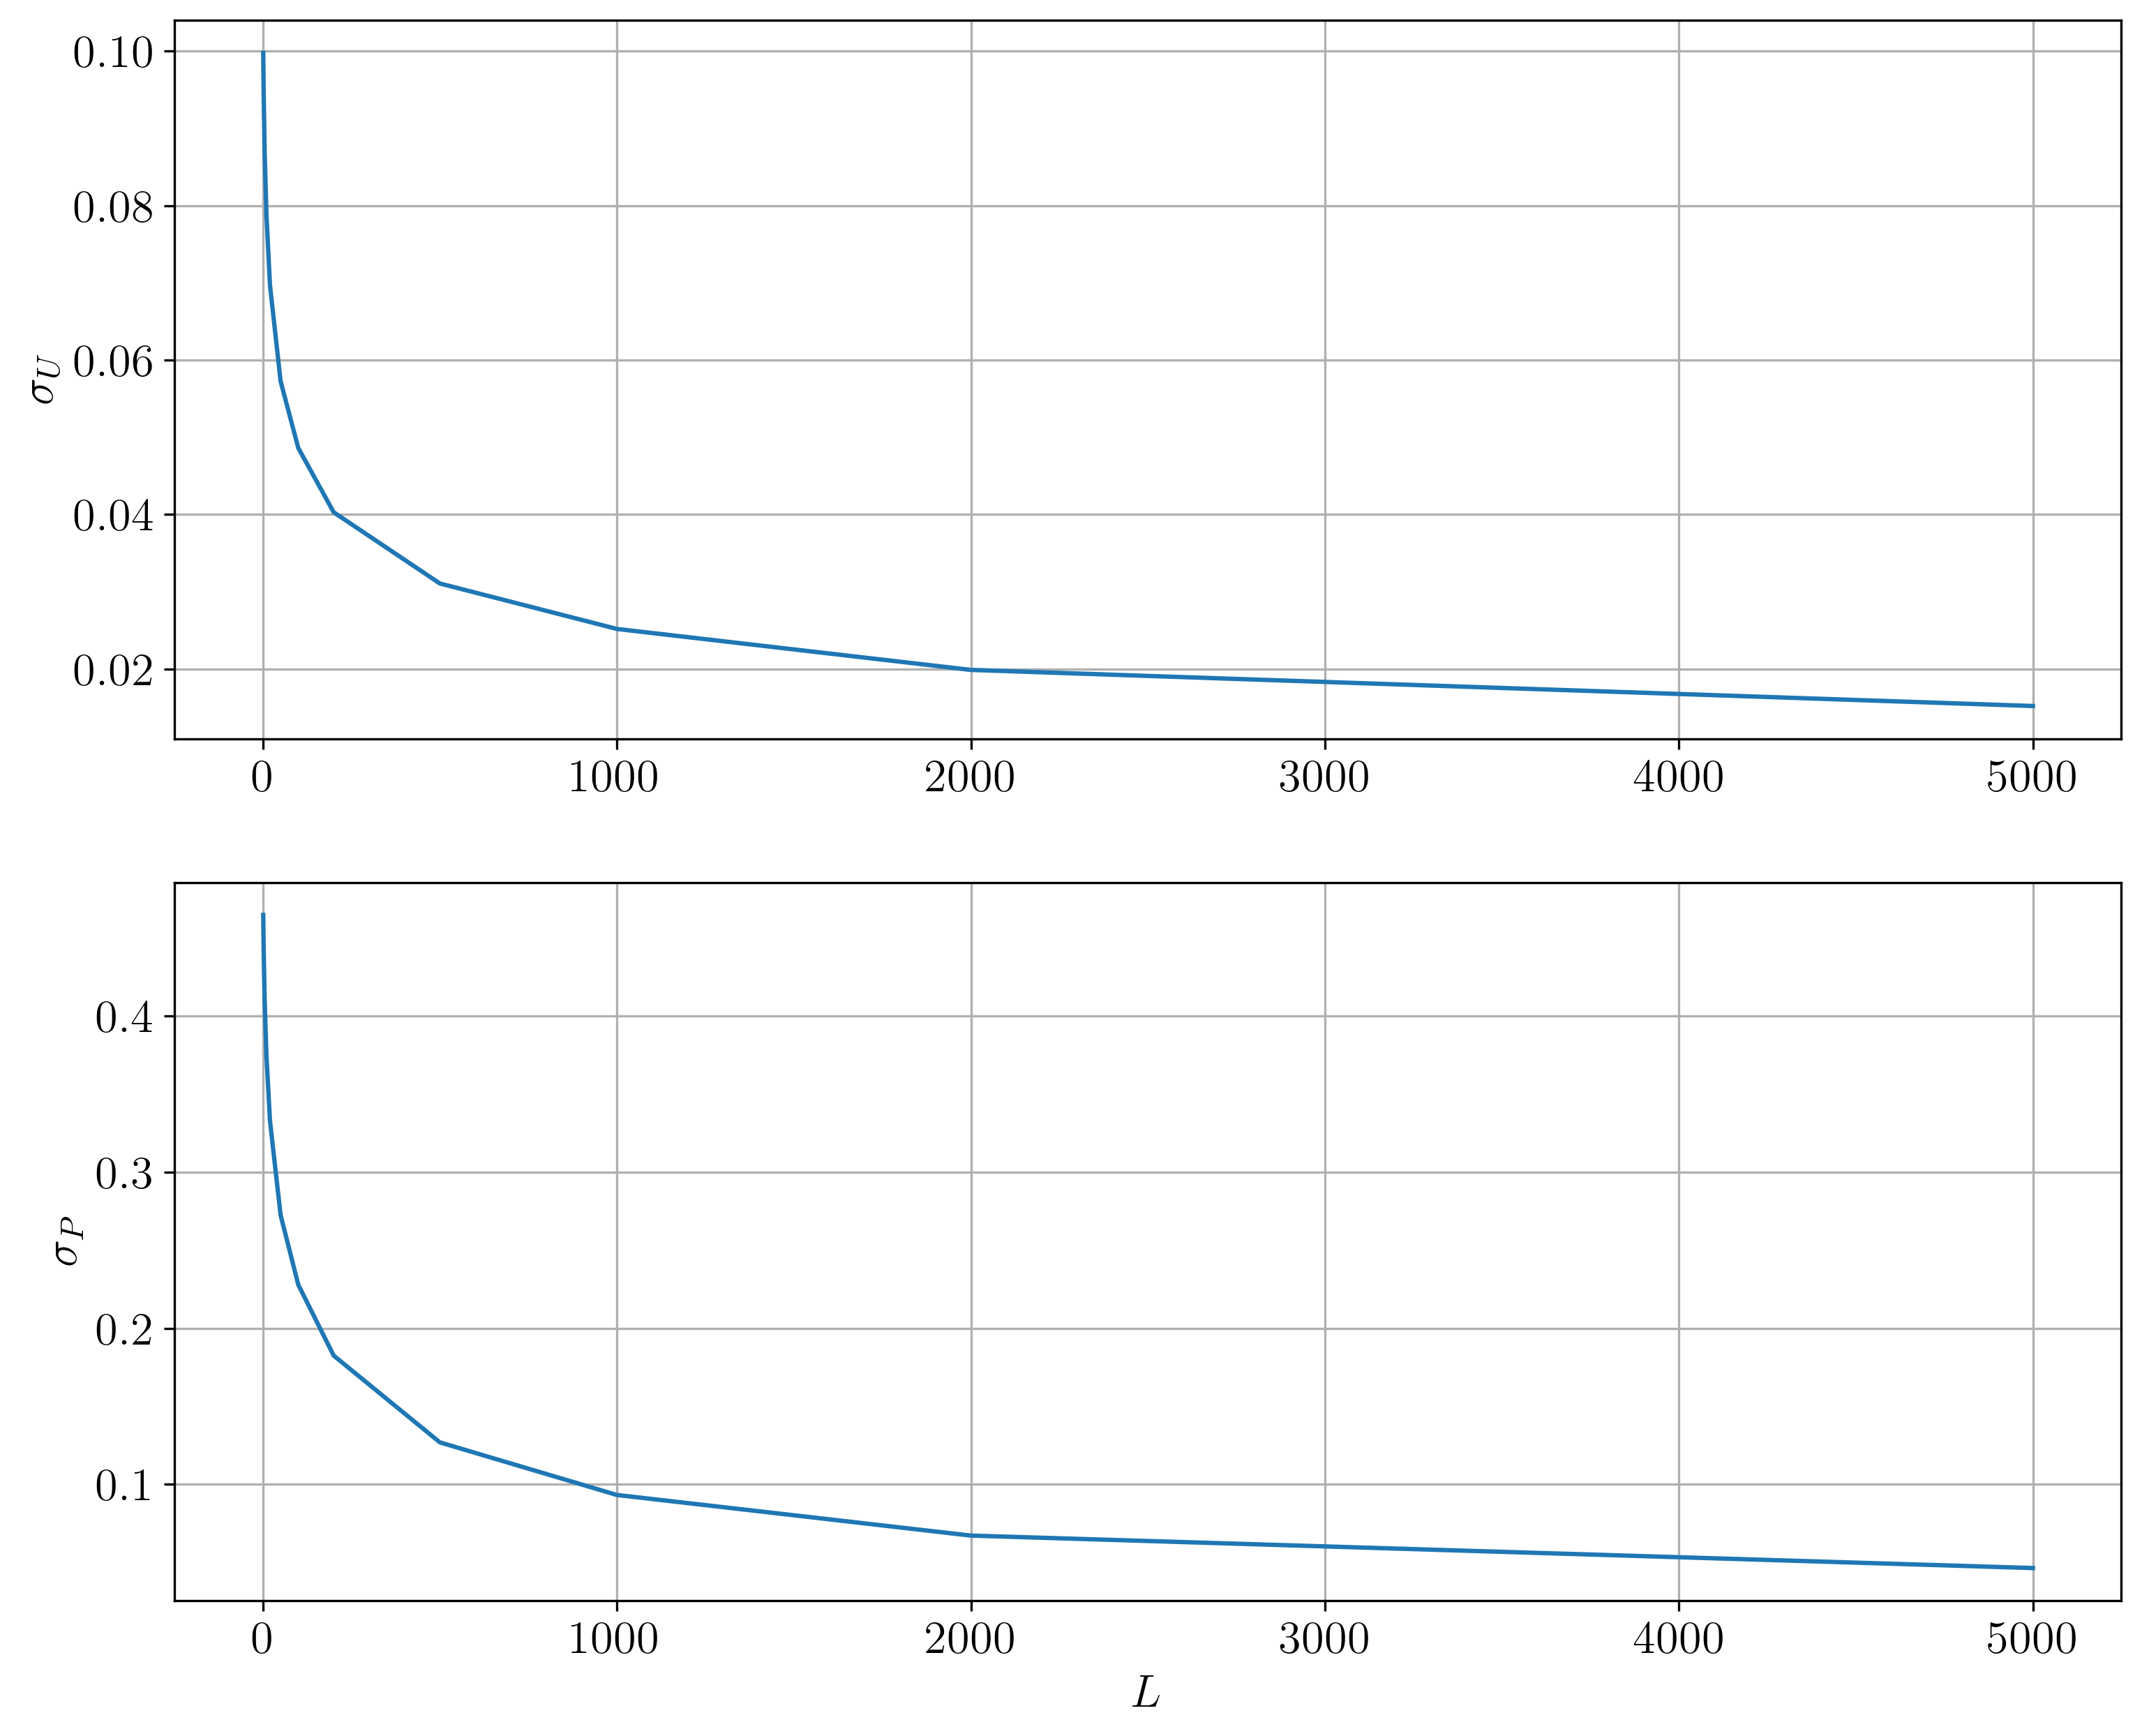

In [20]:
fig, axs = plt.subplots(2,1, figsize=(12,10), dpi=300)

axs[0].plot(L, err_u2*np.sqrt(N))
axs[0].set_ylabel("$\sigma_U$")
axs[1].set_ylabel("$\sigma_P$")
axs[1].set_xlabel("$L$")
axs[1].plot(L, err_p2*np.sqrt(N))

axs[0].grid(True)
axs[1].grid(True)
plt.show()

### <span style=color:darkblue> GAS </span>

I equilibrated starting from a fcc configuration.
I run the simulation with transition step 2.0 for 5e+5 MC steps.

**Equilibration**

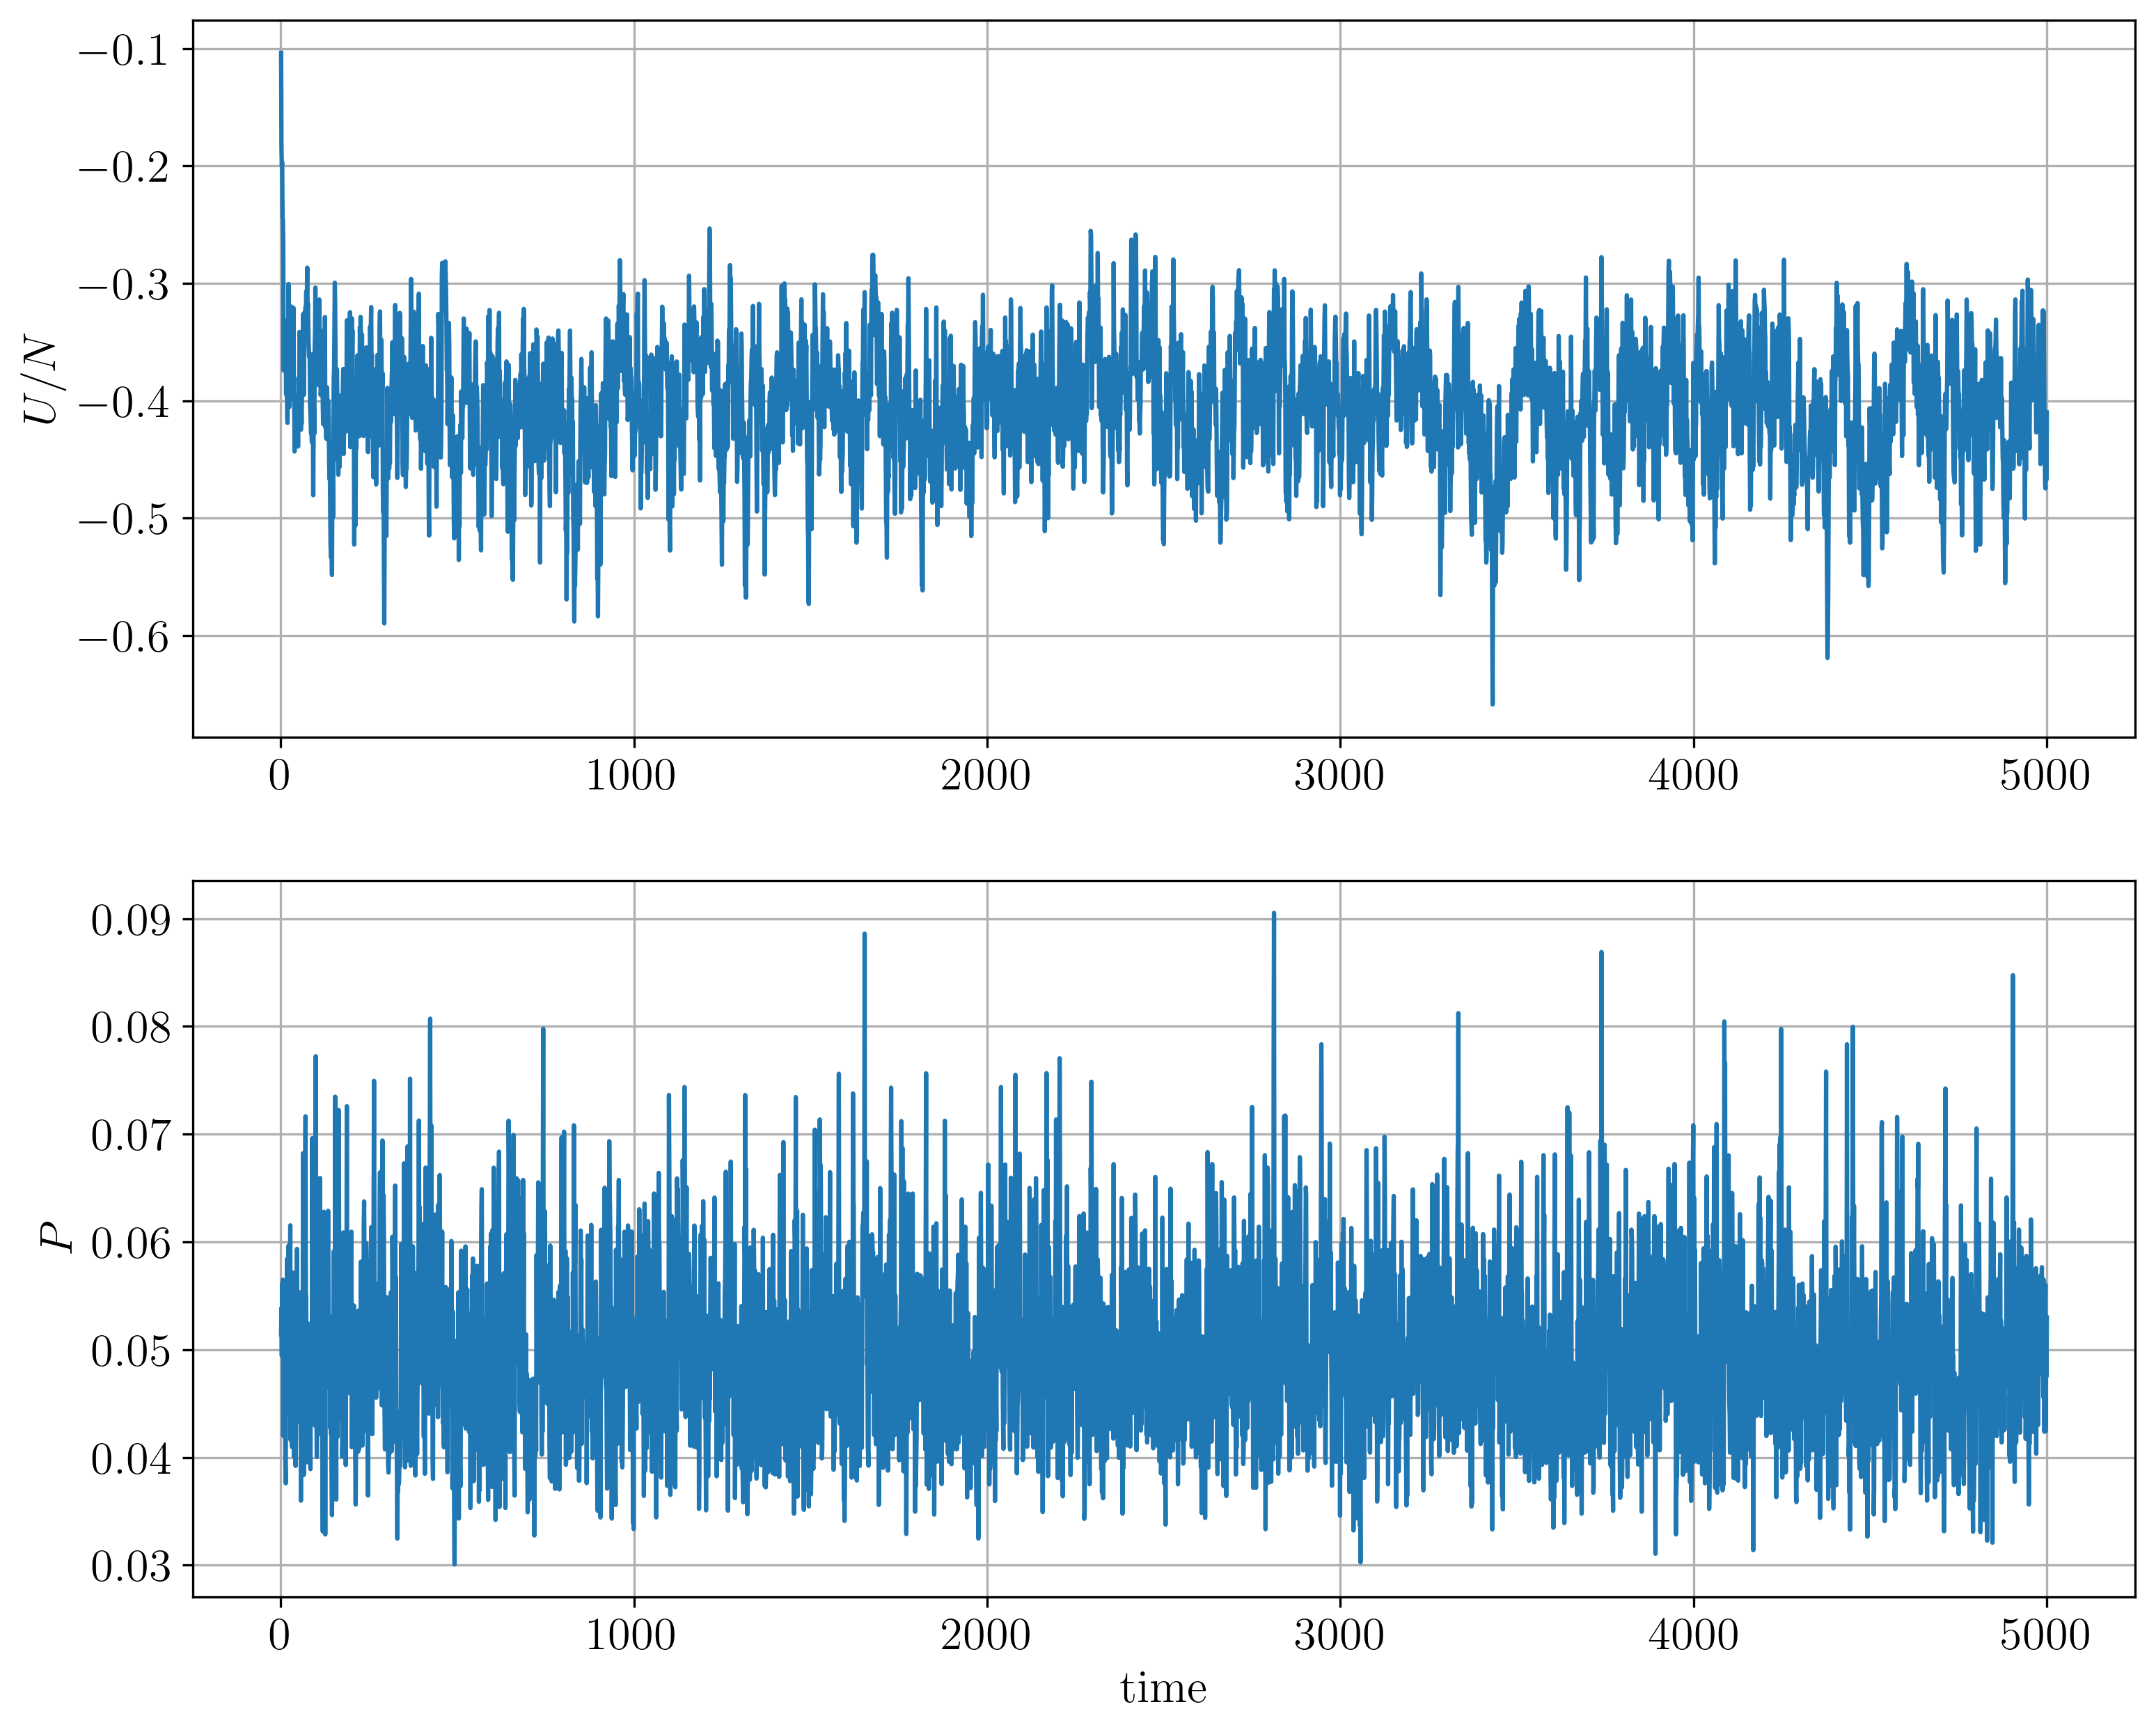

In [21]:
fig, axs = plt.subplots(2,1, figsize=(12,10), dpi=300)
u = np.loadtxt("./MDNVE_MCNVT/data/MC/equilibration_gas_output_epot.dat", usecols=1)
p = np.loadtxt("./MDNVE_MCNVT/data/MC/equilibration_gas_output_pres.dat", usecols=1)
x = np.arange(1,len(u)+1)
axs[0].plot(x,u)
axs[1].plot(x,p)
axs[0].set_ylabel("$U/N$")
axs[1].set_ylabel("$P$")
axs[1].set_xlabel("time")
axs[0].grid(True)
axs[1].grid(True)

plt.show()

**Autocorrelation functions**

In [22]:
u3 = np.loadtxt("./MDNVE_MCNVT/data/MC/gas_output_etot.dat", usecols=1, unpack=True)
p3 = np.loadtxt("./MDNVE_MCNVT/data/MC/gas_output_pres.dat", usecols=1, unpack=True)

In [23]:
E3 = np.array([])
P3 = np.array([])
for tau in time:
    E3 = np.append(E3, autocorrelation(u3, tau))
    P3 = np.append(P3, autocorrelation(p3, tau))

In [24]:
u3_opt, u3_cov = curve_fit(exp, time, E3)
p3_opt, p3_cov = curve_fit(exp, time, P3)
print("Fit of autocorrelation function with an exponential:")
print("Energy\t\t Pressure\n*************\t *************")
print(f"a   = {u3_opt[0]:.3f}\t a   = {p3_opt[0]:.3f}\nt_c = {u3_opt[1]:.3f}\t t_c = {p3_opt[1]:.3f}")

Fit of autocorrelation function with an exponential:
Energy		 Pressure
*************	 *************
a   = 0.827	 a   = 0.998
t_c = 8.302	 t_c = 0.997


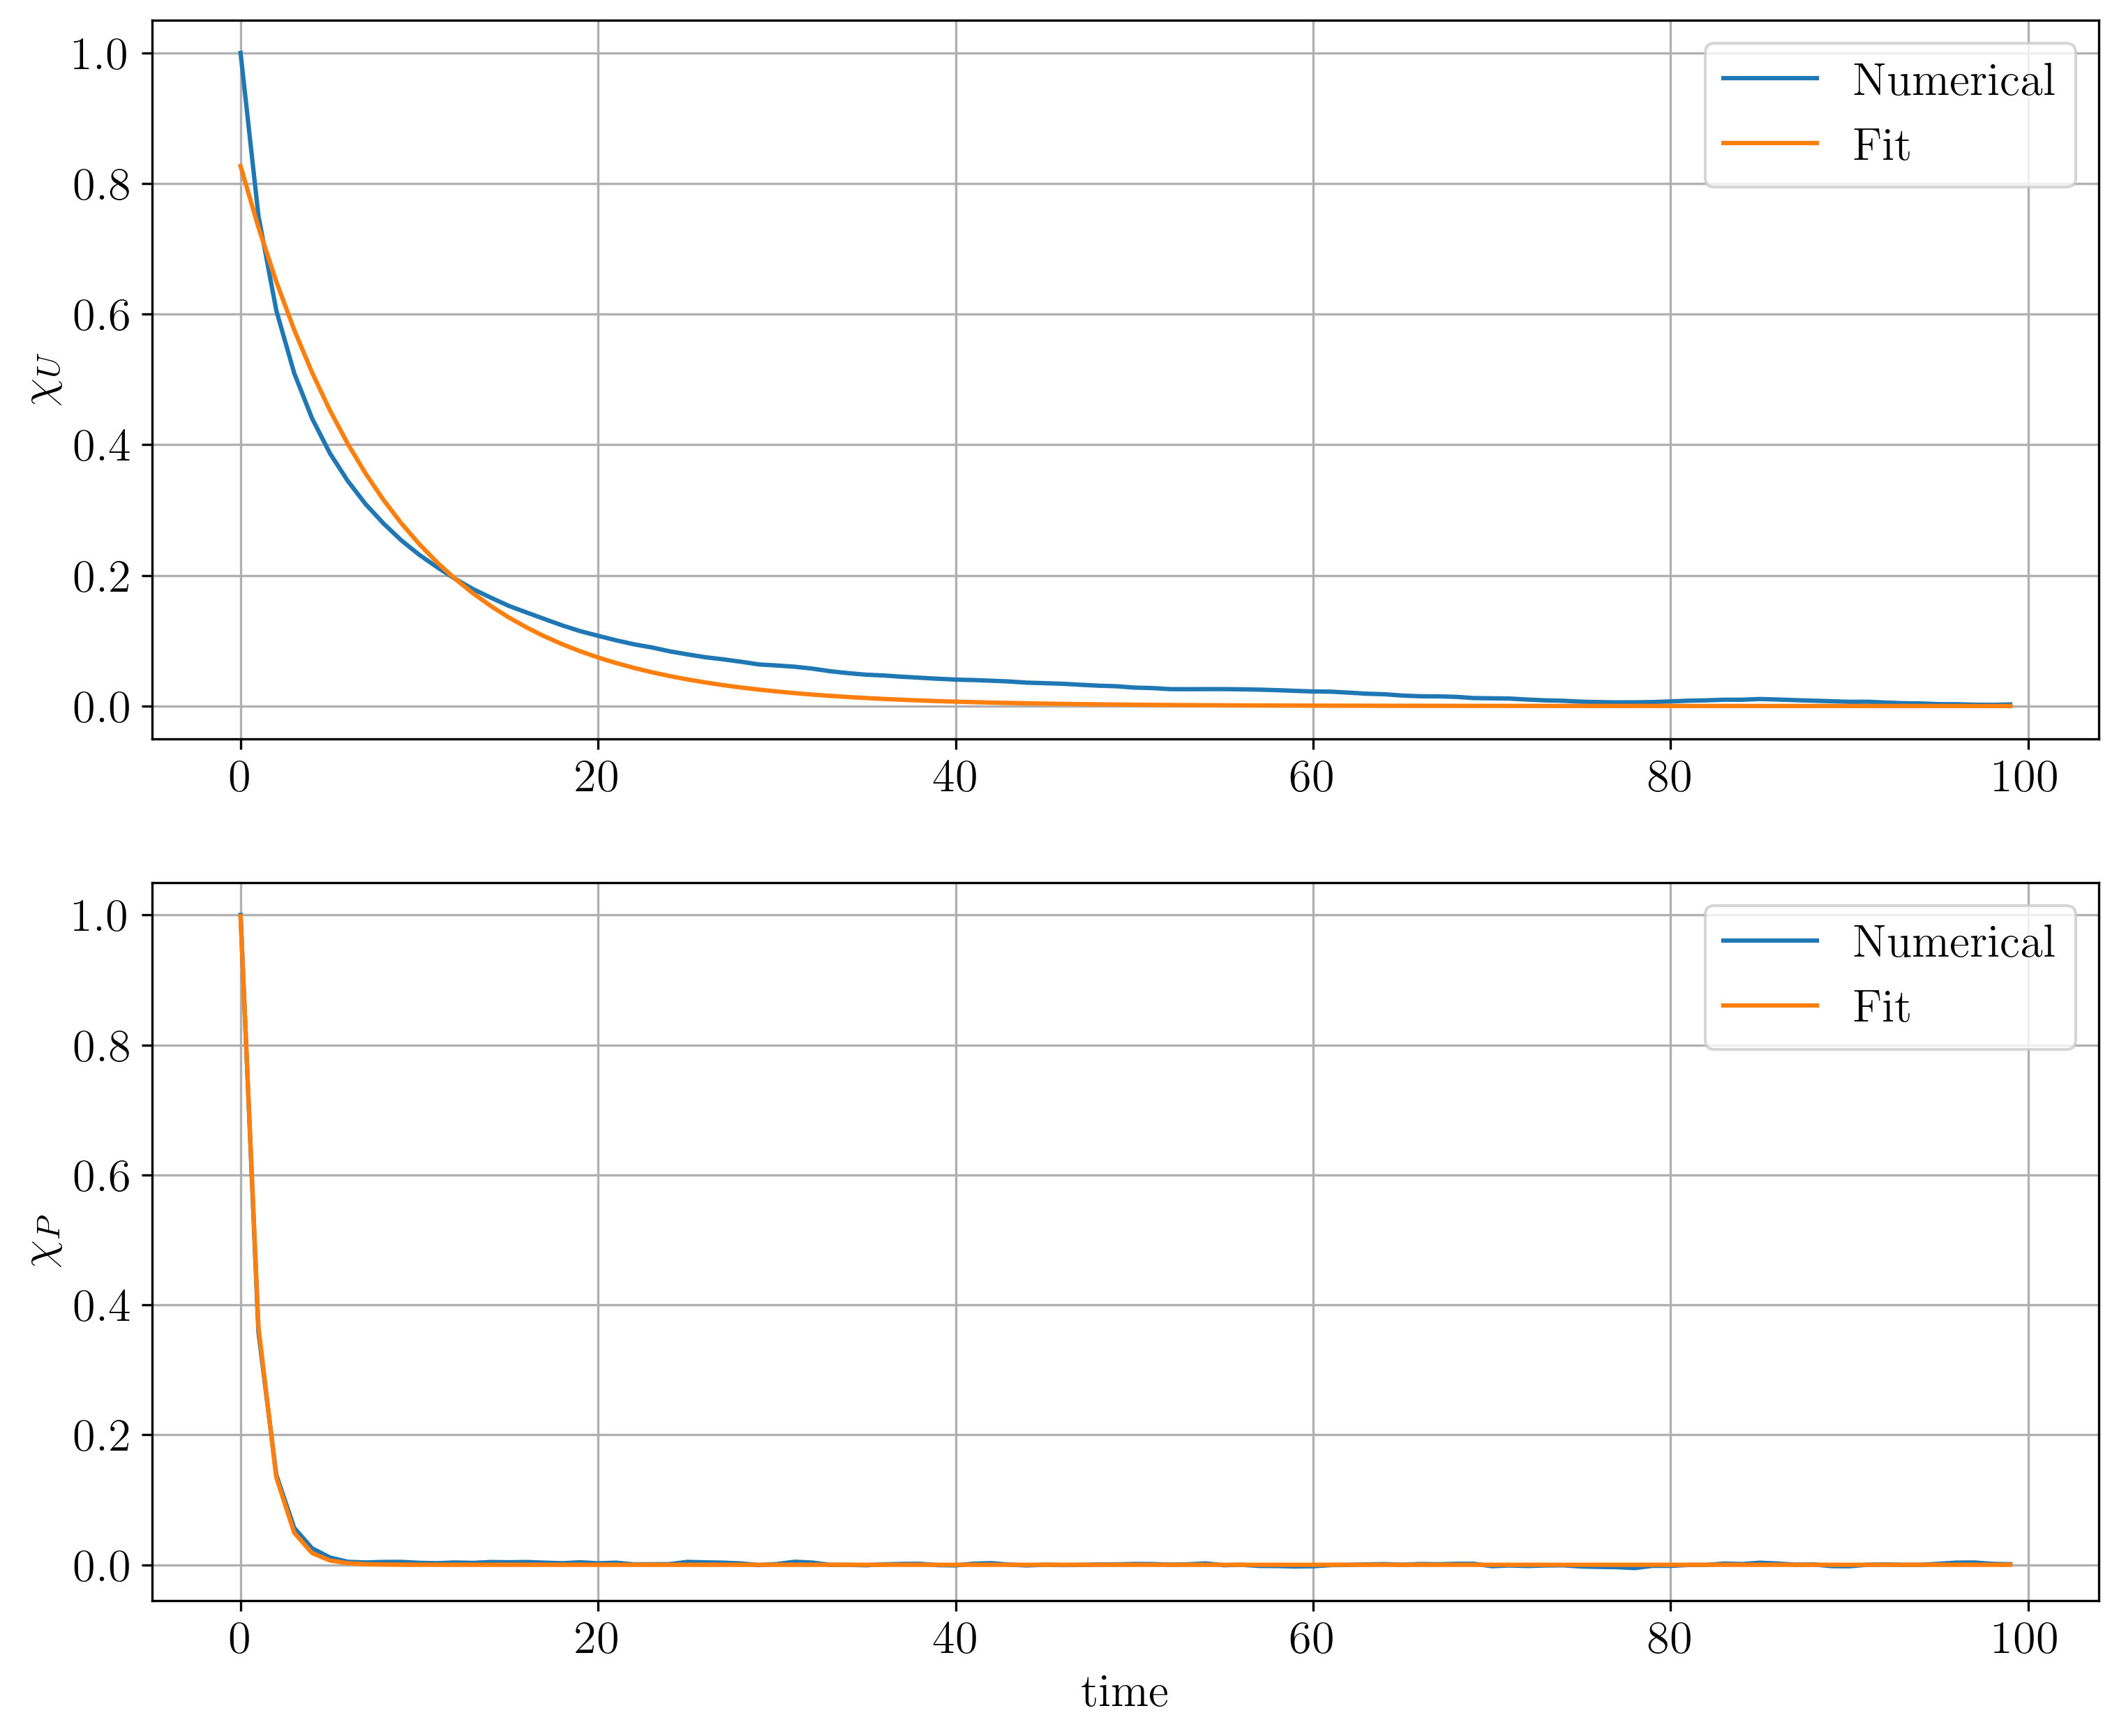

In [25]:
fig, axs = plt.subplots(2,1, figsize=(12,10), dpi=300)

axs[0].plot(time, E3, label="Numerical")
axs[0].plot(time, exp(time, u3_opt[0], u3_opt[1]), label="Fit")
axs[0].set_ylabel("$\chi_U$")
axs[1].set_ylabel("$\chi_P$")
axs[1].set_xlabel("time")
axs[1].plot(time, P3, label="Numerical")
axs[1].plot(time, exp(time, p3_opt[0], p3_opt[1]), label="Fit")


axs[0].legend()
axs[1].legend()
axs[0].grid(True)
axs[1].grid(True)
plt.show()

**Block size dependence of the statistical error**

In [26]:
L = np.array([1,2,5,10,20,50,100,200,500,1000,2000,5000]) # Throws per block
M = len(u3) # Throws
N = M/L # Blocks
err_u3 = np.array([]) # Errors as functions of L
err_p3 = np.array([])

for i in range(len(L)):
    blk_avgs_u = np.array([])
    blk_avgs_p = np.array([])
    for j in range(int(N[i])):
        blk_avgs_u = np.append(blk_avgs_u, u3[j*L[i]:(j+1)*L[i]].mean())
        blk_avgs_p = np.append(blk_avgs_p, p3[j*L[i]:(j+1)*L[i]].mean())
    u_avg = blk_avgs_u.mean()
    p_avg = blk_avgs_p.mean()
    tmp_u = blk_avgs_u*blk_avgs_u
    tmp_p = blk_avgs_p*blk_avgs_p
    u2_avg = tmp_u.mean()
    p2_avg = tmp_p.mean()
    err_u3 = np.append(err_u3, ((u2_avg - u_avg**2)/N[i])**.5)
    err_p3 = np.append(err_p3, ((p2_avg - p_avg**2)/N[i])**.5)

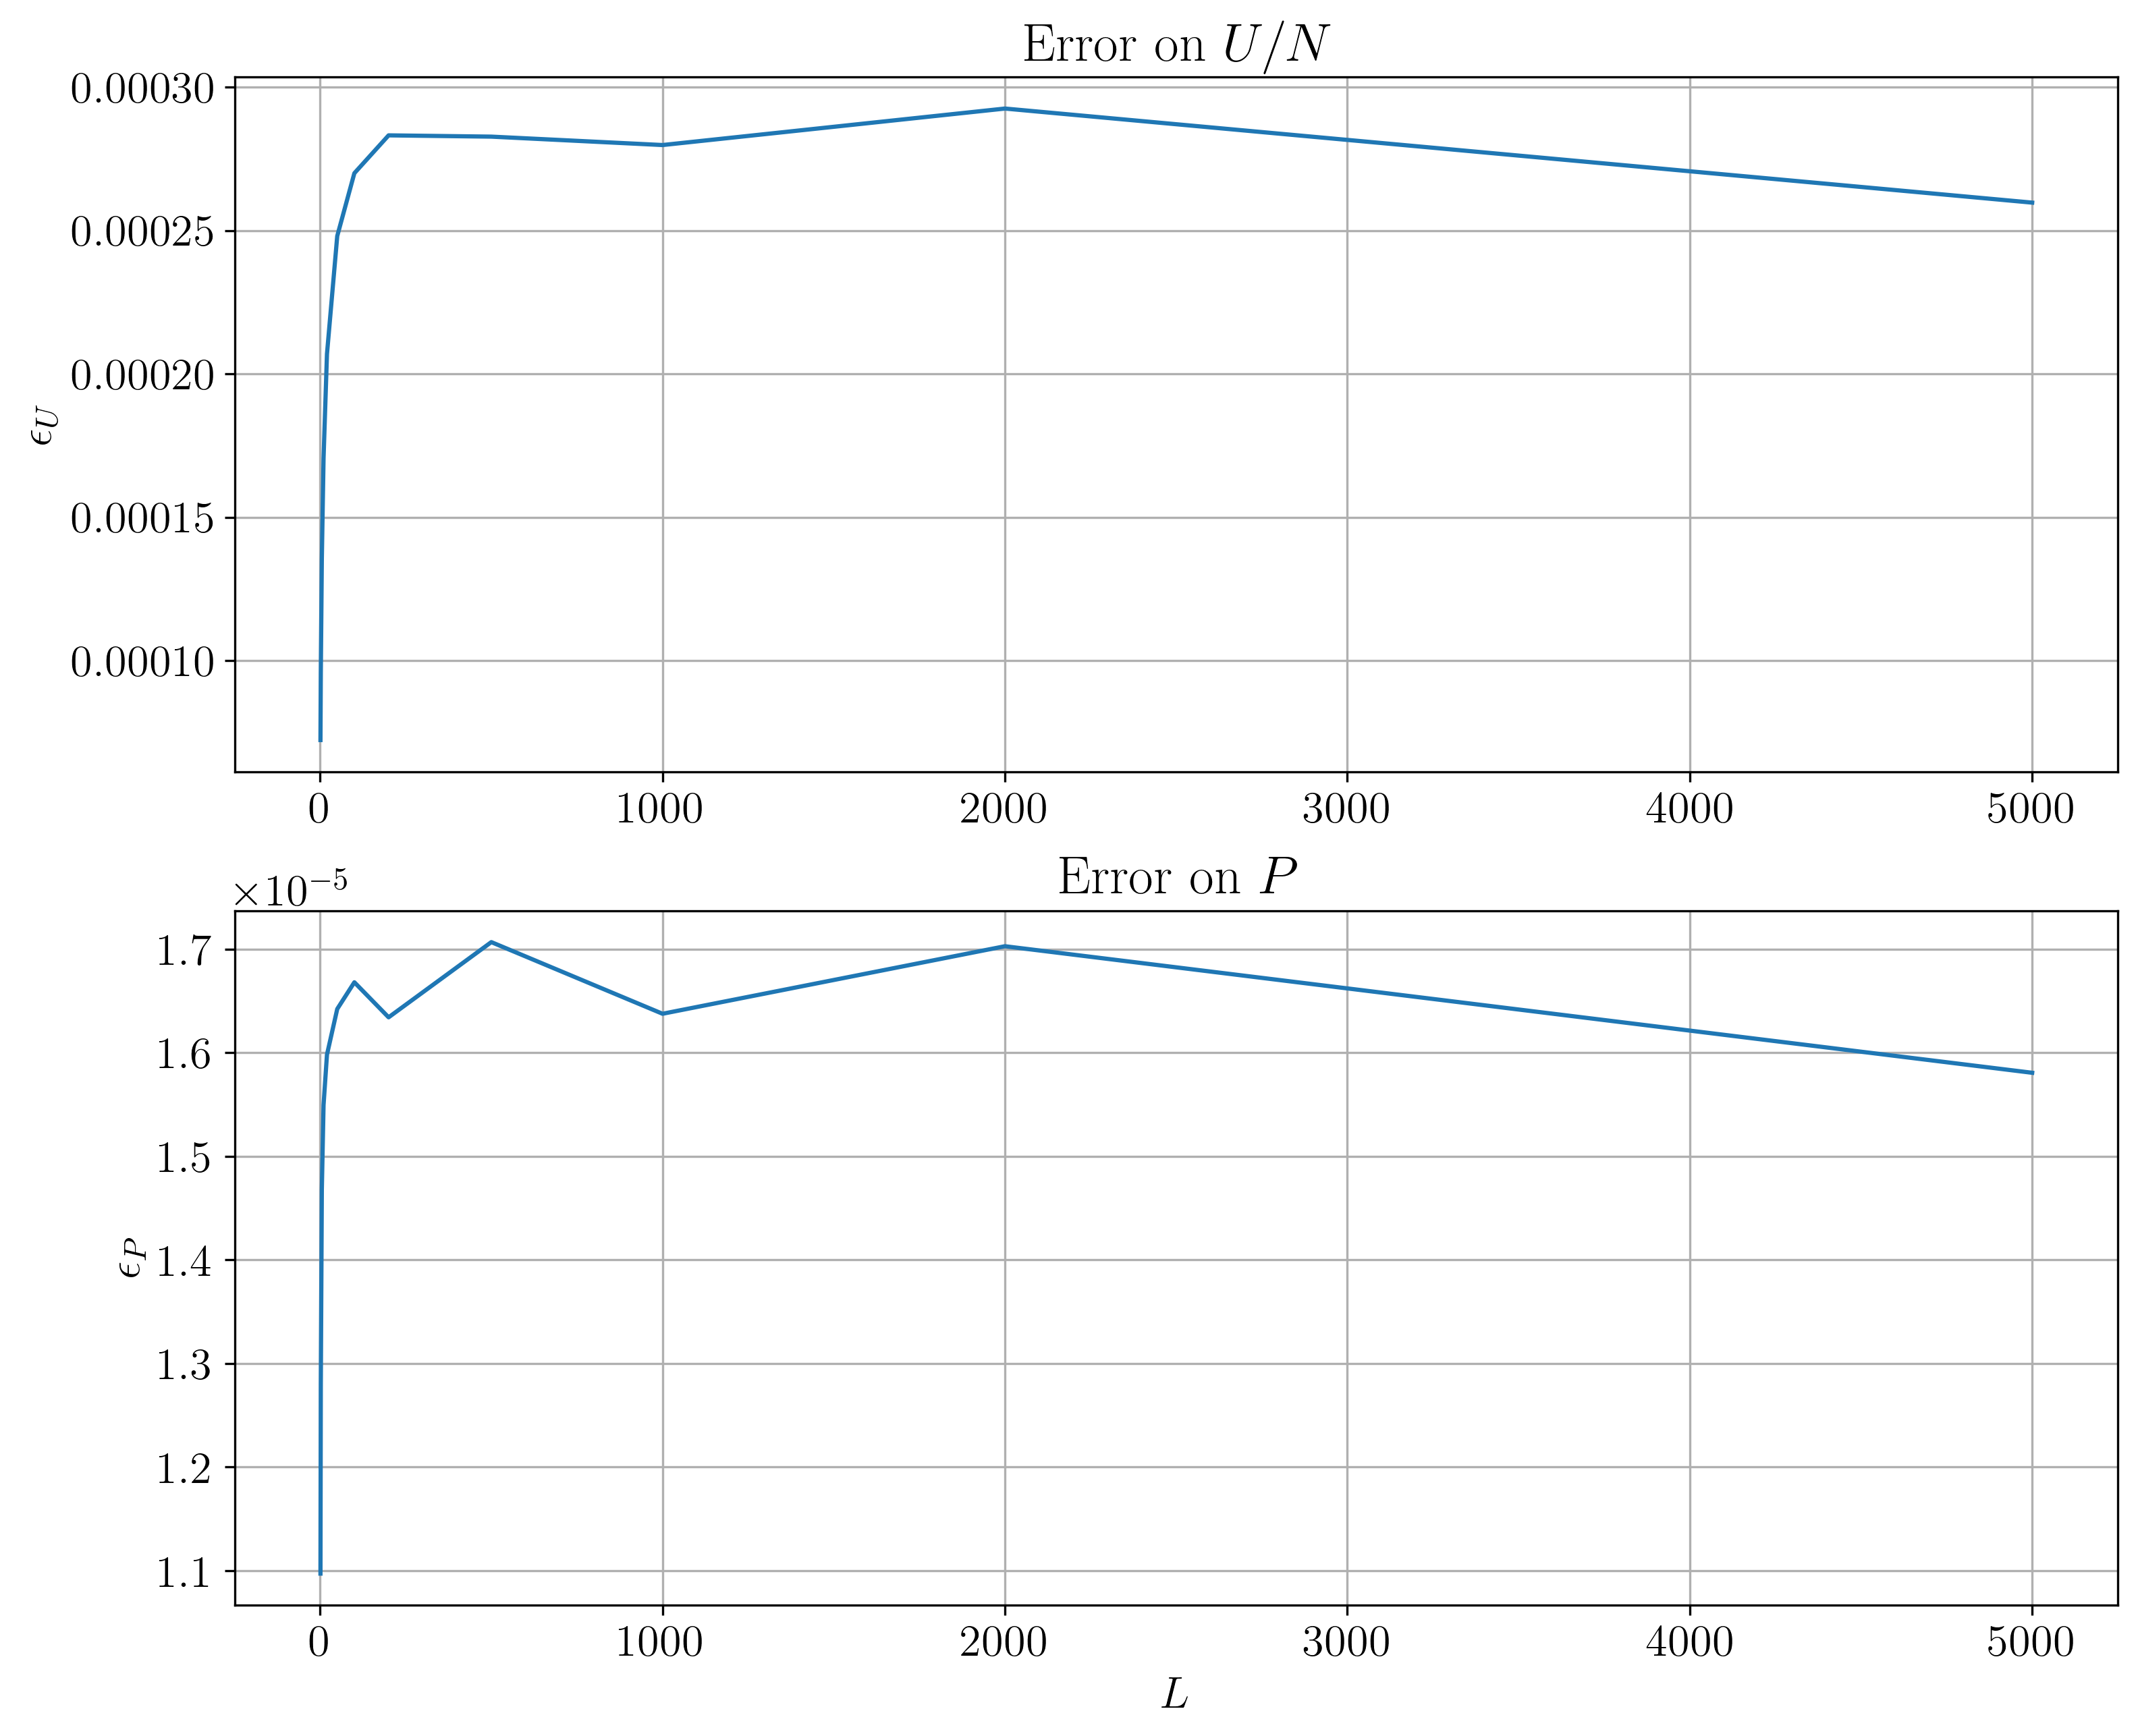

In [27]:
fig, axs = plt.subplots(2,1, figsize=(12,10), dpi=300)

axs[0].plot(L, err_u3)
axs[0].set_ylabel("$\epsilon_U$")
axs[0].set_title("Error on $U/N$")
axs[1].set_ylabel("$\epsilon_P$")
axs[1].set_xlabel("$L$")
axs[1].set_title("Error on $P$")
axs[1].plot(L, err_p3)

axs[0].grid(True)
axs[1].grid(True)
plt.show()

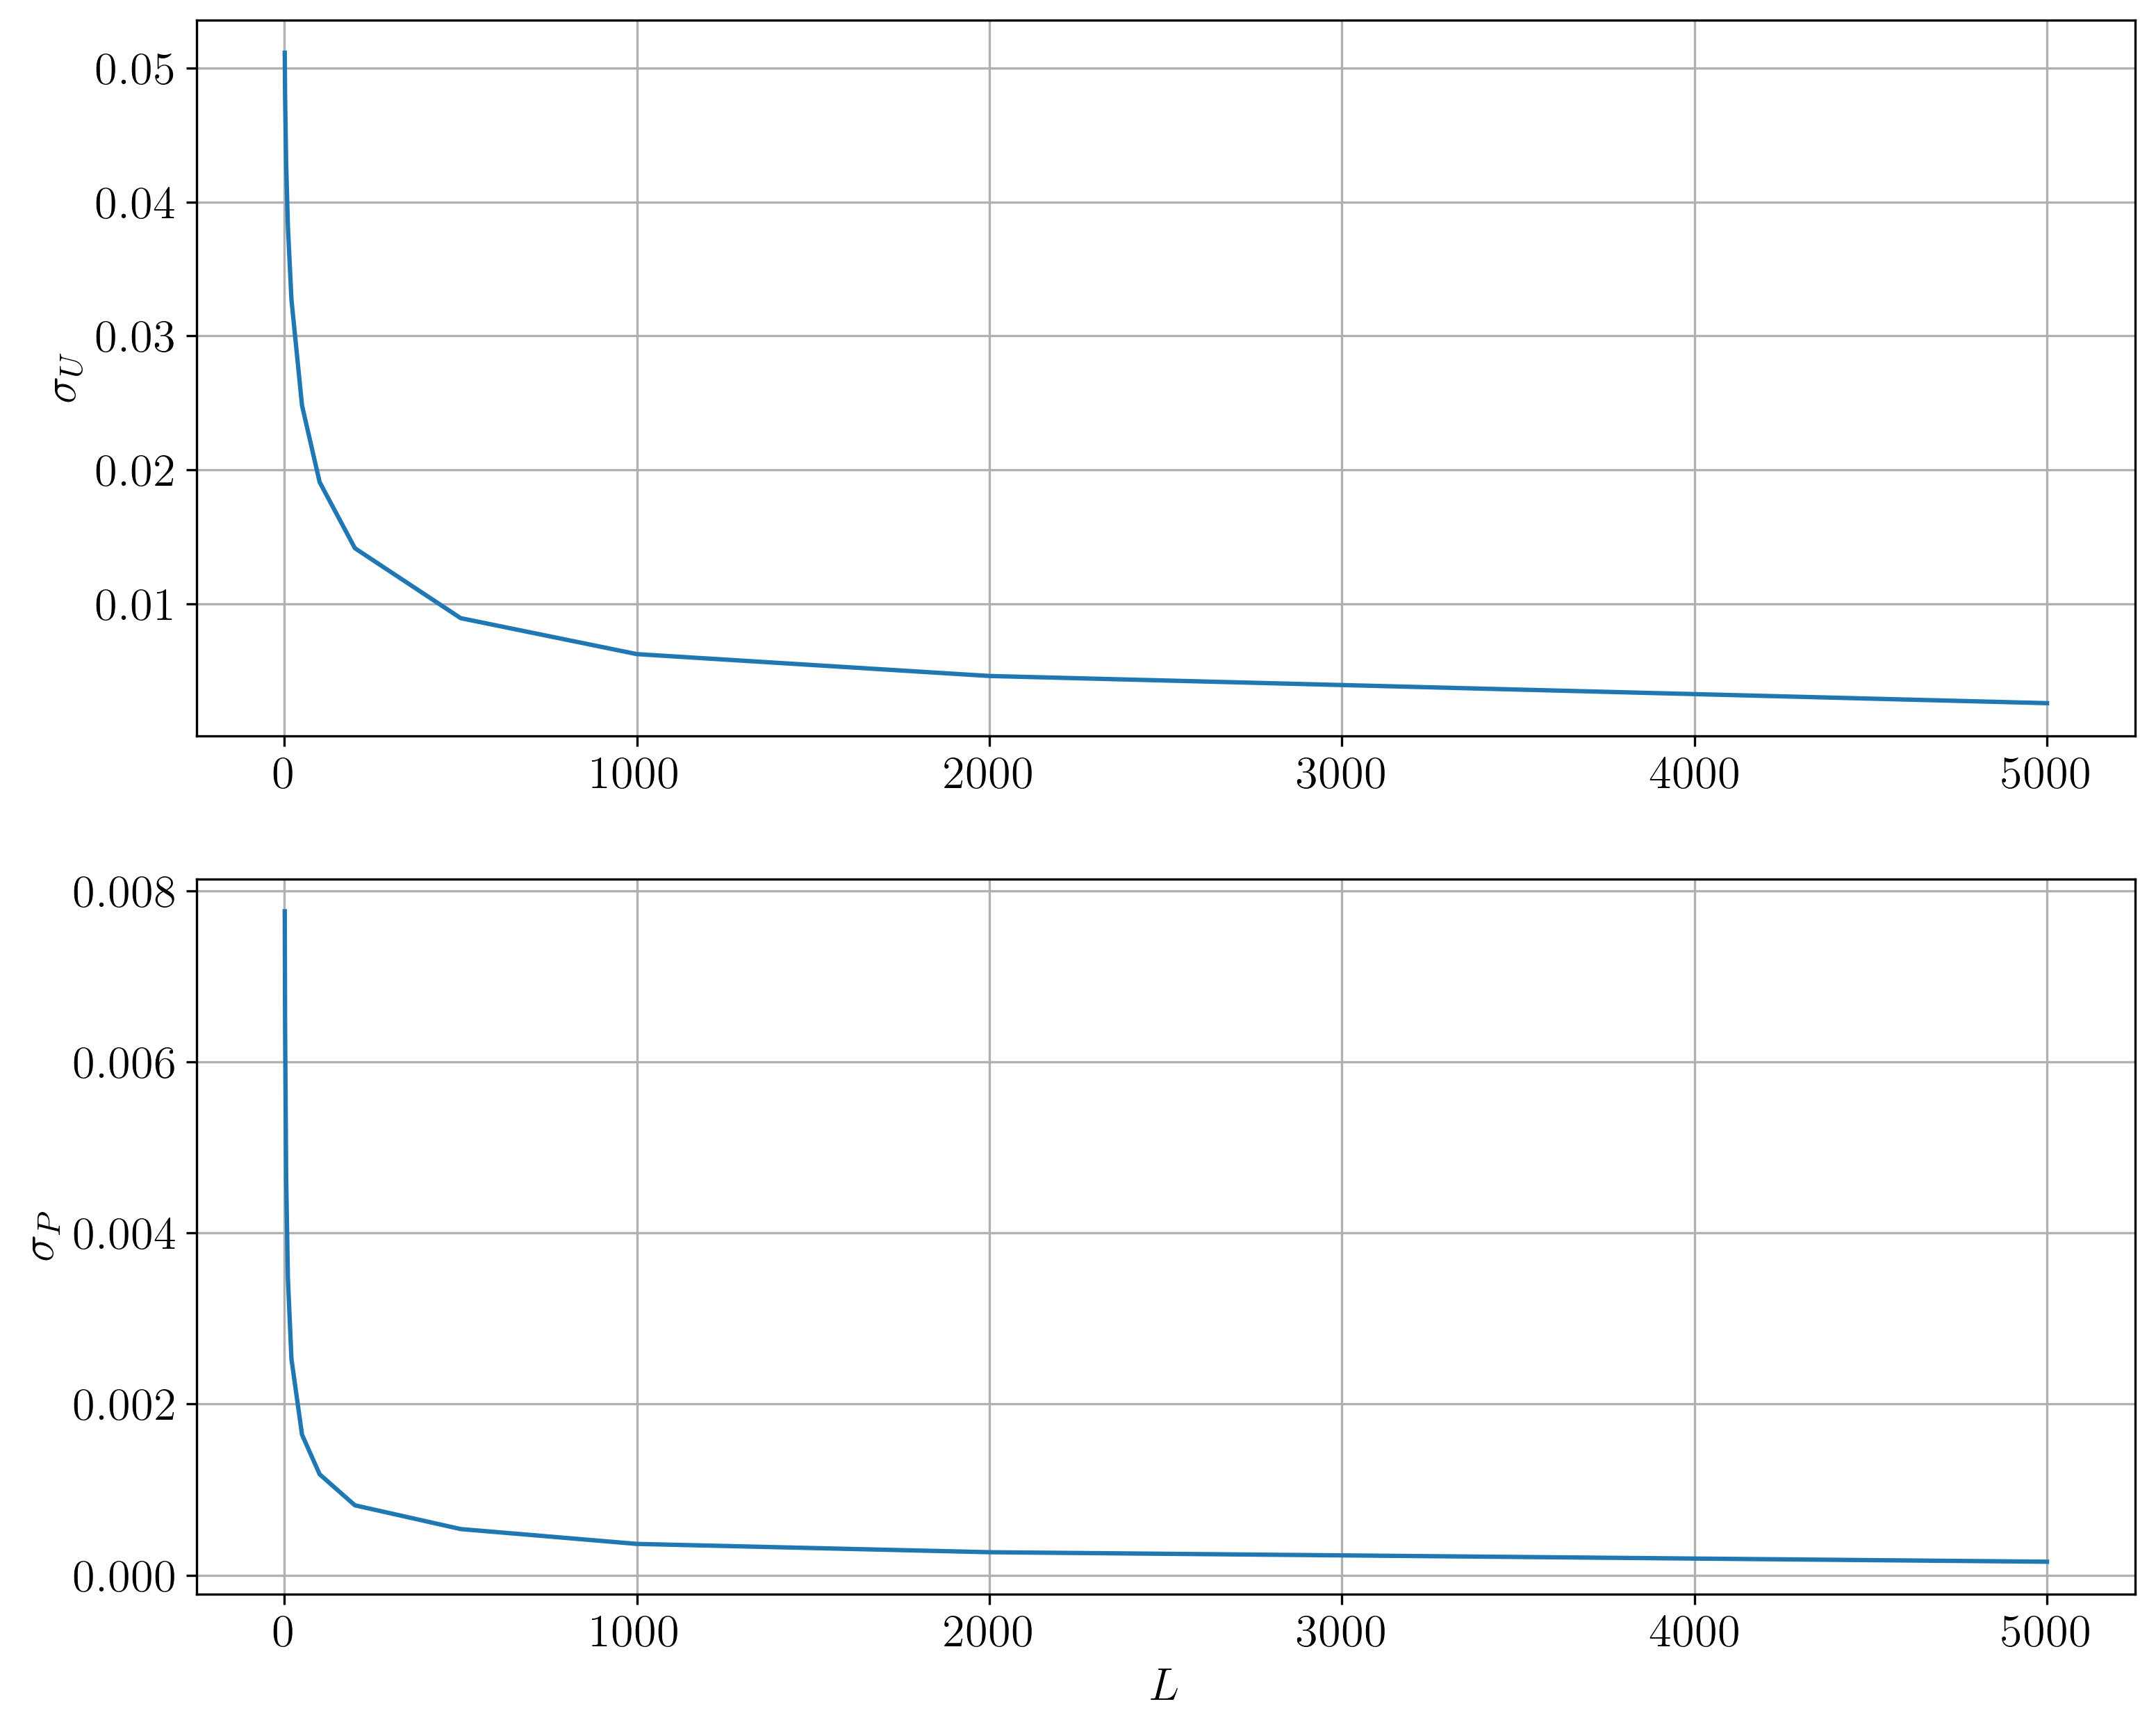

In [28]:
fig, axs = plt.subplots(2,1, figsize=(12,10), dpi=300)

axs[0].plot(L, err_u3*np.sqrt(N))
axs[0].set_ylabel("$\sigma_U$")
axs[1].set_ylabel("$\sigma_P$")
axs[1].set_xlabel("$L$")
axs[1].plot(L, err_p3*np.sqrt(N))

axs[0].grid(True)
axs[1].grid(True)
plt.show()

### Exercise 07.3

<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the MD/MC code</span>: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

### Exercise 07.4

By means of your upgraded MD/MC code, equilibrate and <span style="color:red">perform MC NVT simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... <span style="color:red"> and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.</span>

### <span style=color:darkblue> SOLID </span>
After equilibration (5000 MC steps) I run the simulation for 20 blocks, 2000 steps per block, with transition step 0.12.

I did MD equilibration as in Numerical Exercise 4, that is a I performed a series of 5000 steps simulation runs starting each run from the configuration of the last run (the first run started from the fcc configuration).

Then I run the MD simulation for 20 blocks, 2000 steps per block.
I repeated the same procedure for all the MD runs.

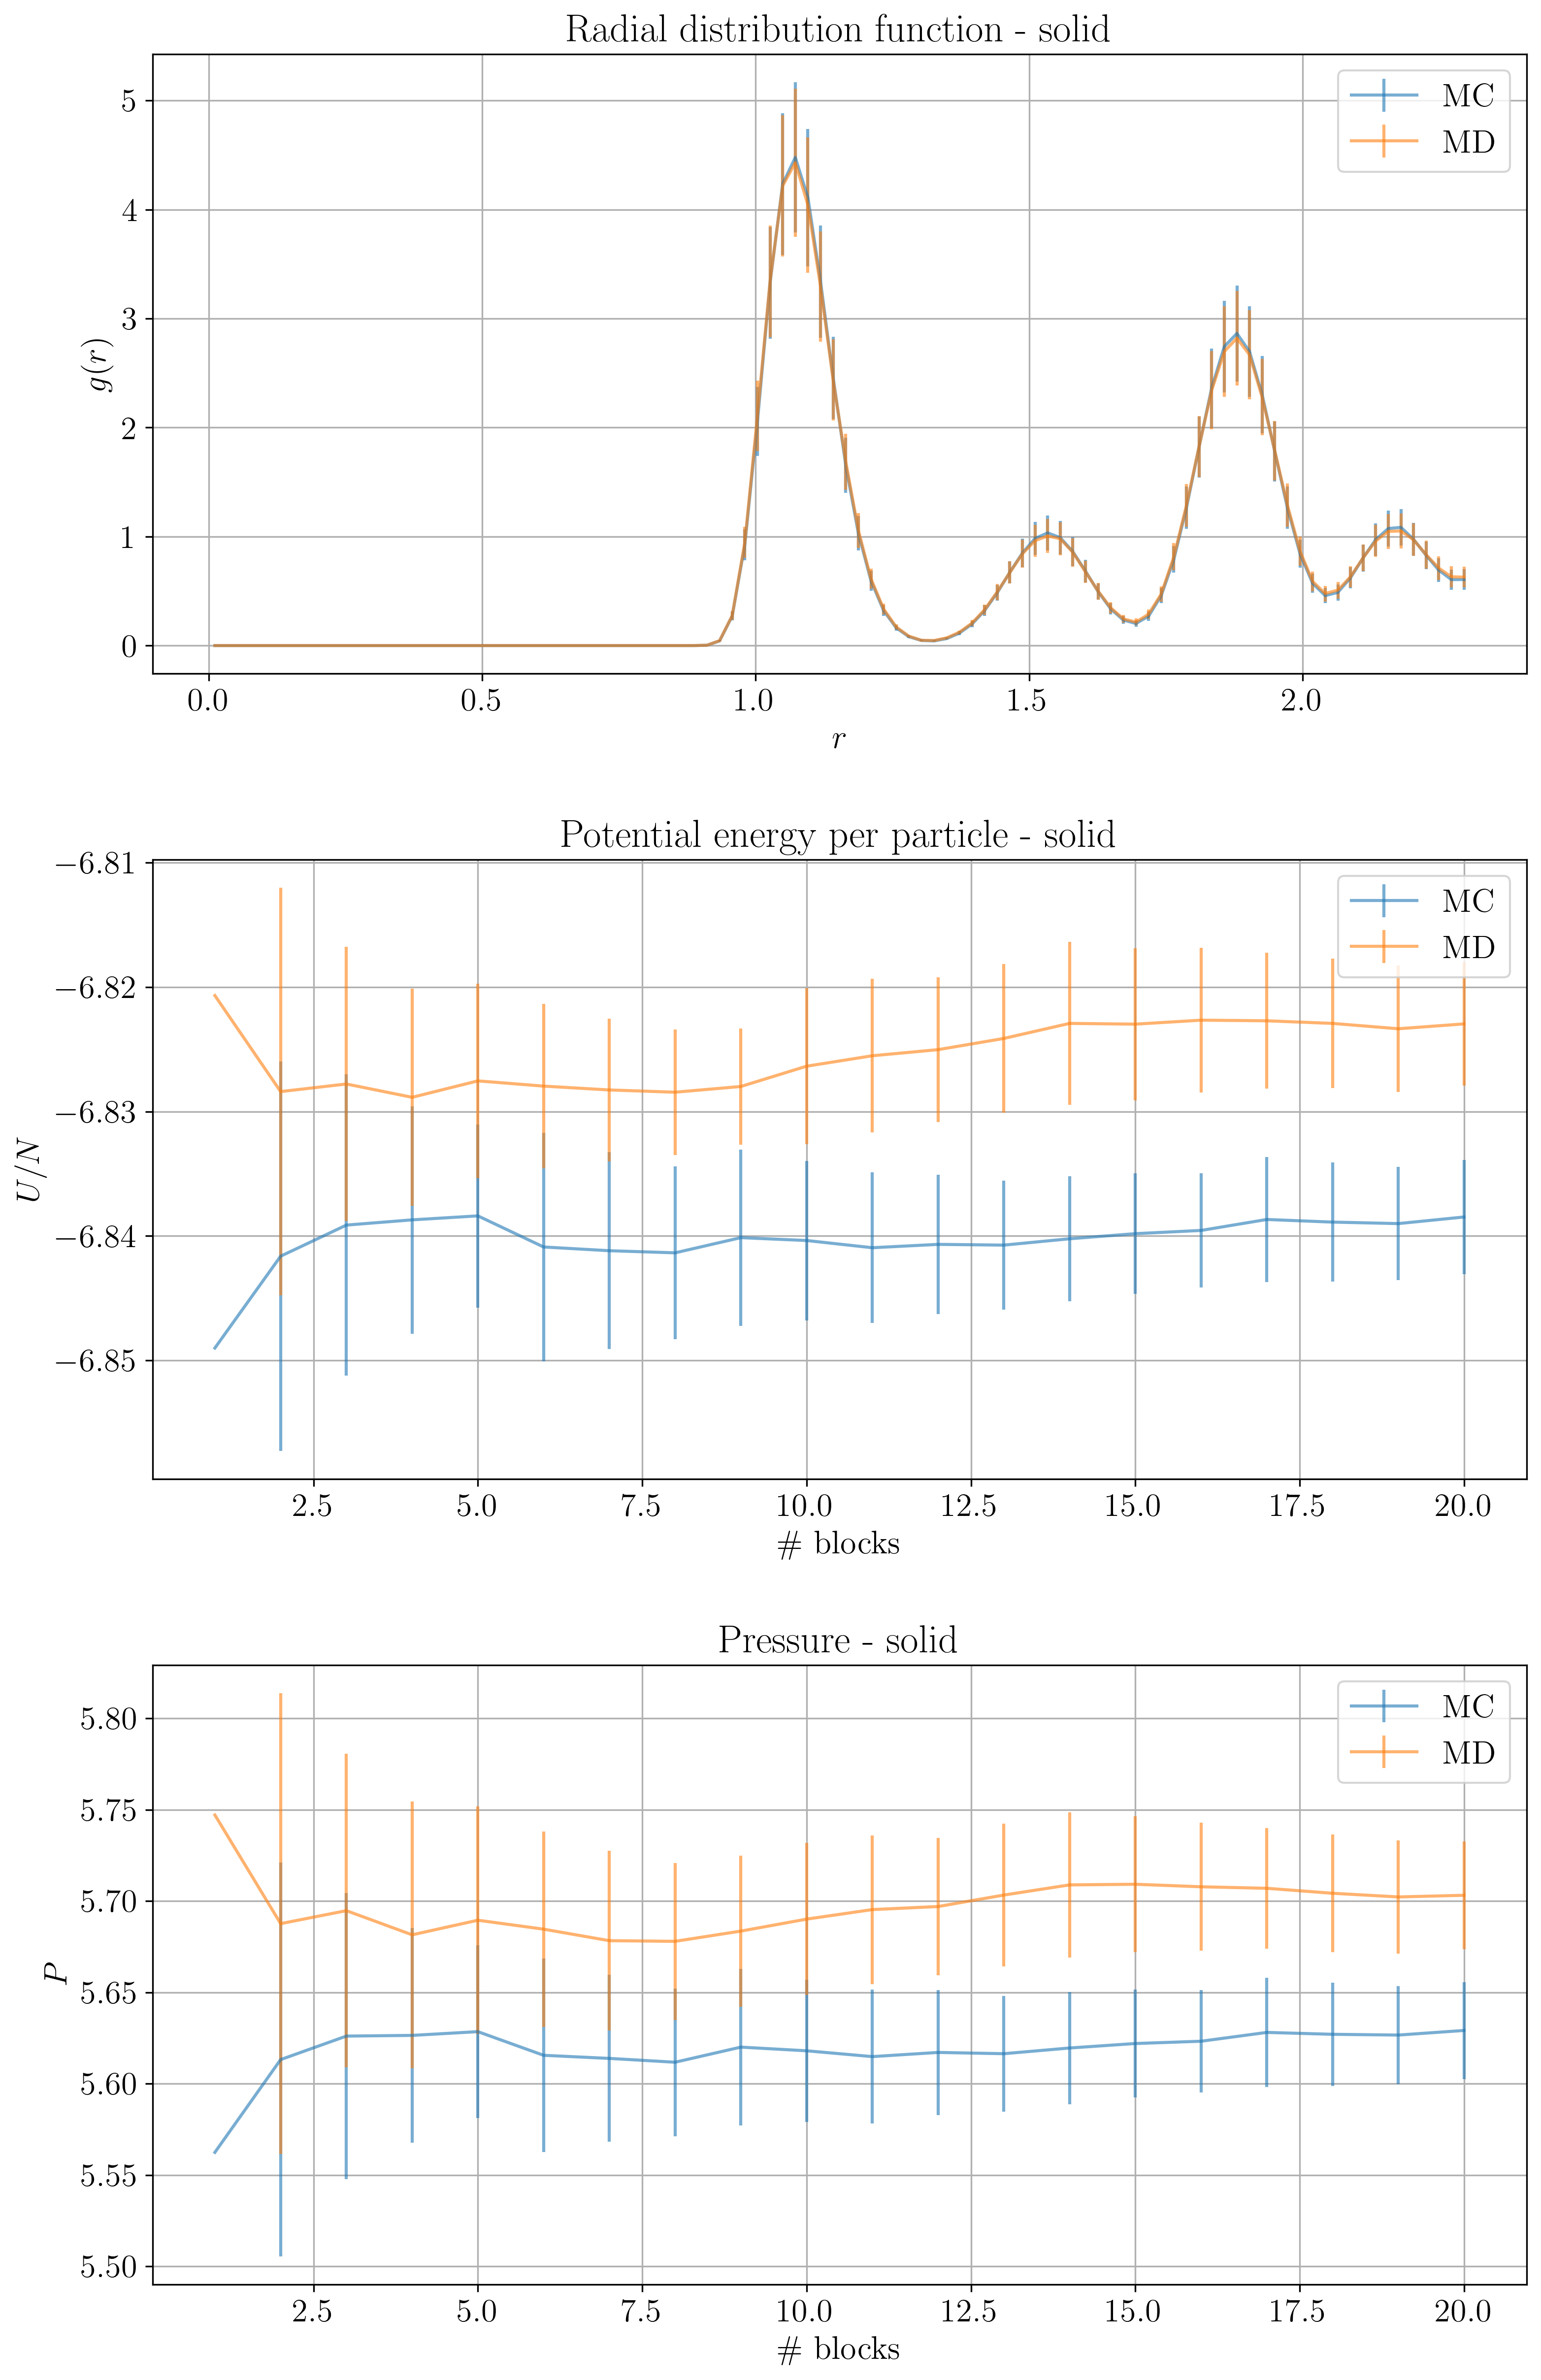

In [29]:
fig, axs = plt.subplots(3,1,figsize=(12,20), dpi=300)

r1, g1, err1 = np.loadtxt("MDNVE_MCNVT/data/MC/07.4/solid_output_final_gdir.dat", usecols=(1,3,4), unpack=True)
r2, g2, err2 = np.loadtxt("MDNVE_MCNVT/data/MD/07.4/solid_output_final_gdir.dat", usecols=(1,3,4), unpack=True)

axs[0].errorbar(r1,g1,yerr=3*err1, label="MC", alpha=0.6)
axs[0].errorbar(r2,g2,yerr=3*err2, label="MD", alpha=0.6)
axs[0].set_xlabel("$r$")
axs[0].set_ylabel("$g(r)$")
axs[0].set_title("Radial distribution function - solid")
axs[0].legend()
axs[0].grid(True)

r1, g1, err1 = np.loadtxt("MDNVE_MCNVT/data/MC/07.4/solid_output_epot.dat", usecols=(0,2,3), unpack=True)
r2, g2, err2 = np.loadtxt("MDNVE_MCNVT/data/MD/07.4/solid_output_epot.dat", usecols=(0,2,3), unpack=True)

axs[1].errorbar(r1,g1,yerr=3*err1, label="MC", alpha=0.6)
axs[1].errorbar(r2,g2,yerr=3*err2, label="MD", alpha=0.6)
axs[1].set_xlabel("\# blocks")
axs[1].set_ylabel("$U/N$")
axs[1].set_title("Potential energy per particle - solid")
axs[1].legend()
axs[1].grid(True)

r1, g1, err1 = np.loadtxt("MDNVE_MCNVT/data/MC/07.4/solid_output_pres.dat", usecols=(0,2,3), unpack=True)
r2, g2, err2 = np.loadtxt("MDNVE_MCNVT/data/MD/07.4/solid_output_pres.dat", usecols=(0,2,3), unpack=True)

axs[2].errorbar(r1,g1,yerr=3*err1, label="MC", alpha=0.6)
axs[2].errorbar(r2,g2,yerr=3*err2, label="MD", alpha=0.6)
axs[2].set_xlabel("\# blocks")
axs[2].set_ylabel("$P$")
axs[2].set_title("Pressure - solid")
axs[2].legend()
axs[2].grid(True)

plt.subplots_adjust(hspace=0.3)

plt.show()

### <span style=color:darkblue> LIQUID </span>
After equilibration (5000 MC steps) I run the simulation for 20 blocks, 2000 throws per block, with transition step 0.2.

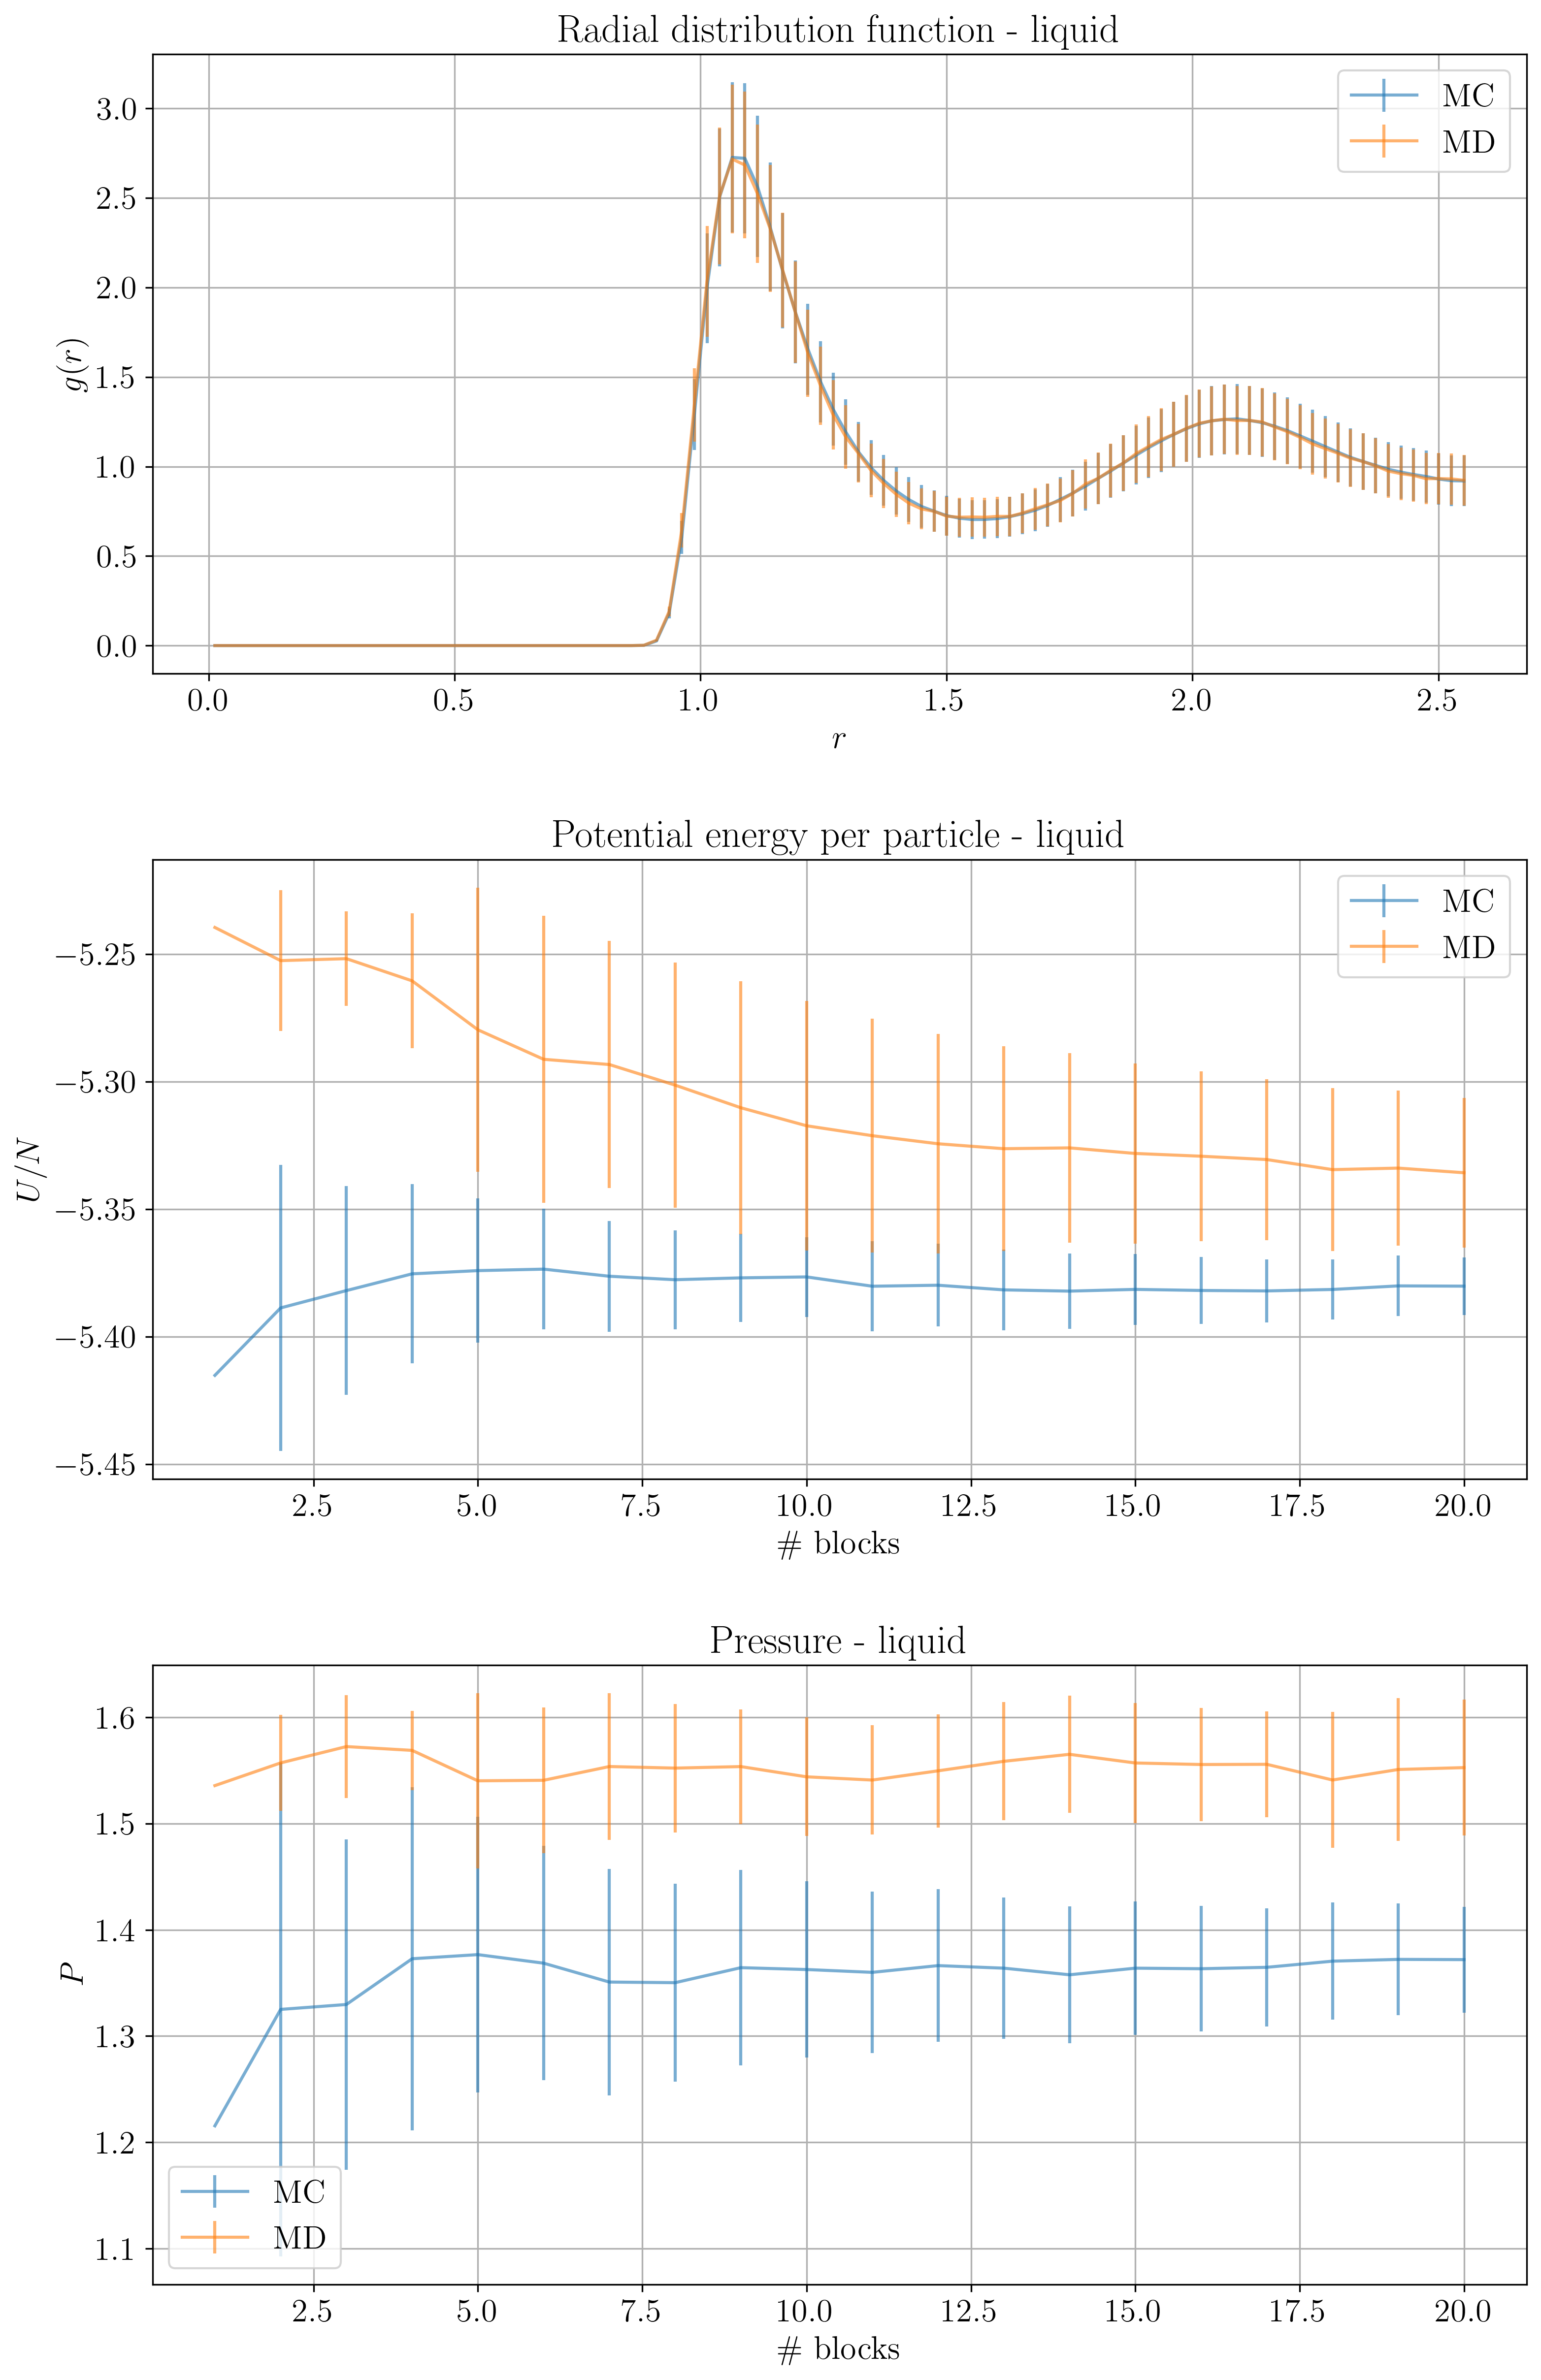

In [30]:
fig, axs = plt.subplots(3,1,figsize=(12,20), dpi=300)

r1, g1, err1 = np.loadtxt("MDNVE_MCNVT/data/MC/07.4/liquid_output_final_gdir.dat", usecols=(1,3,4), unpack=True)
r2, g2, err2 = np.loadtxt("MDNVE_MCNVT/data/MD/07.4/liquid_output_final_gdir.dat", usecols=(1,3,4), unpack=True)

axs[0].errorbar(r1,g1,yerr=3*err1, label="MC", alpha=0.6)
axs[0].errorbar(r2,g2,yerr=3*err2, label="MD", alpha=0.6)
axs[0].set_xlabel("$r$")
axs[0].set_ylabel("$g(r)$")
axs[0].set_title("Radial distribution function - liquid")
axs[0].legend()
axs[0].grid(True)

r1, g1, err1 = np.loadtxt("MDNVE_MCNVT/data/MC/07.4/liquid_output_epot.dat", usecols=(0,2,3), unpack=True)
r2, g2, err2 = np.loadtxt("MDNVE_MCNVT/data/MD/07.4/liquid_output_epot.dat", usecols=(0,2,3), unpack=True)

axs[1].errorbar(r1,g1,yerr=3*err1, label="MC", alpha=0.6)
axs[1].errorbar(r2,g2,yerr=3*err2, label="MD", alpha=0.6)
axs[1].set_xlabel("\# blocks")
axs[1].set_ylabel("$U/N$")
axs[1].set_title("Potential energy per particle - liquid")
axs[1].legend()
axs[1].grid(True)

r1, g1, err1 = np.loadtxt("MDNVE_MCNVT/data/MC/07.4/liquid_output_pres.dat", usecols=(0,2,3), unpack=True)
r2, g2, err2 = np.loadtxt("MDNVE_MCNVT/data/MD/07.4/liquid_output_pres.dat", usecols=(0,2,3), unpack=True)

axs[2].errorbar(r1,g1,yerr=3*err1, label="MC", alpha=0.6)
axs[2].errorbar(r2,g2,yerr=3*err2, label="MD", alpha=0.6)
axs[2].set_xlabel("\# blocks")
axs[2].set_ylabel("$P$")
axs[2].set_title("Pressure - liquid")
axs[2].legend()
axs[2].grid(True)

plt.subplots_adjust(hspace=0.3)

plt.show()

### <span style=color:darkblue> GAS </span>
After equilibration (5000 MC steps) I run the simulation for 20 blocks, 2000 throws per block, with transition step 2.0.

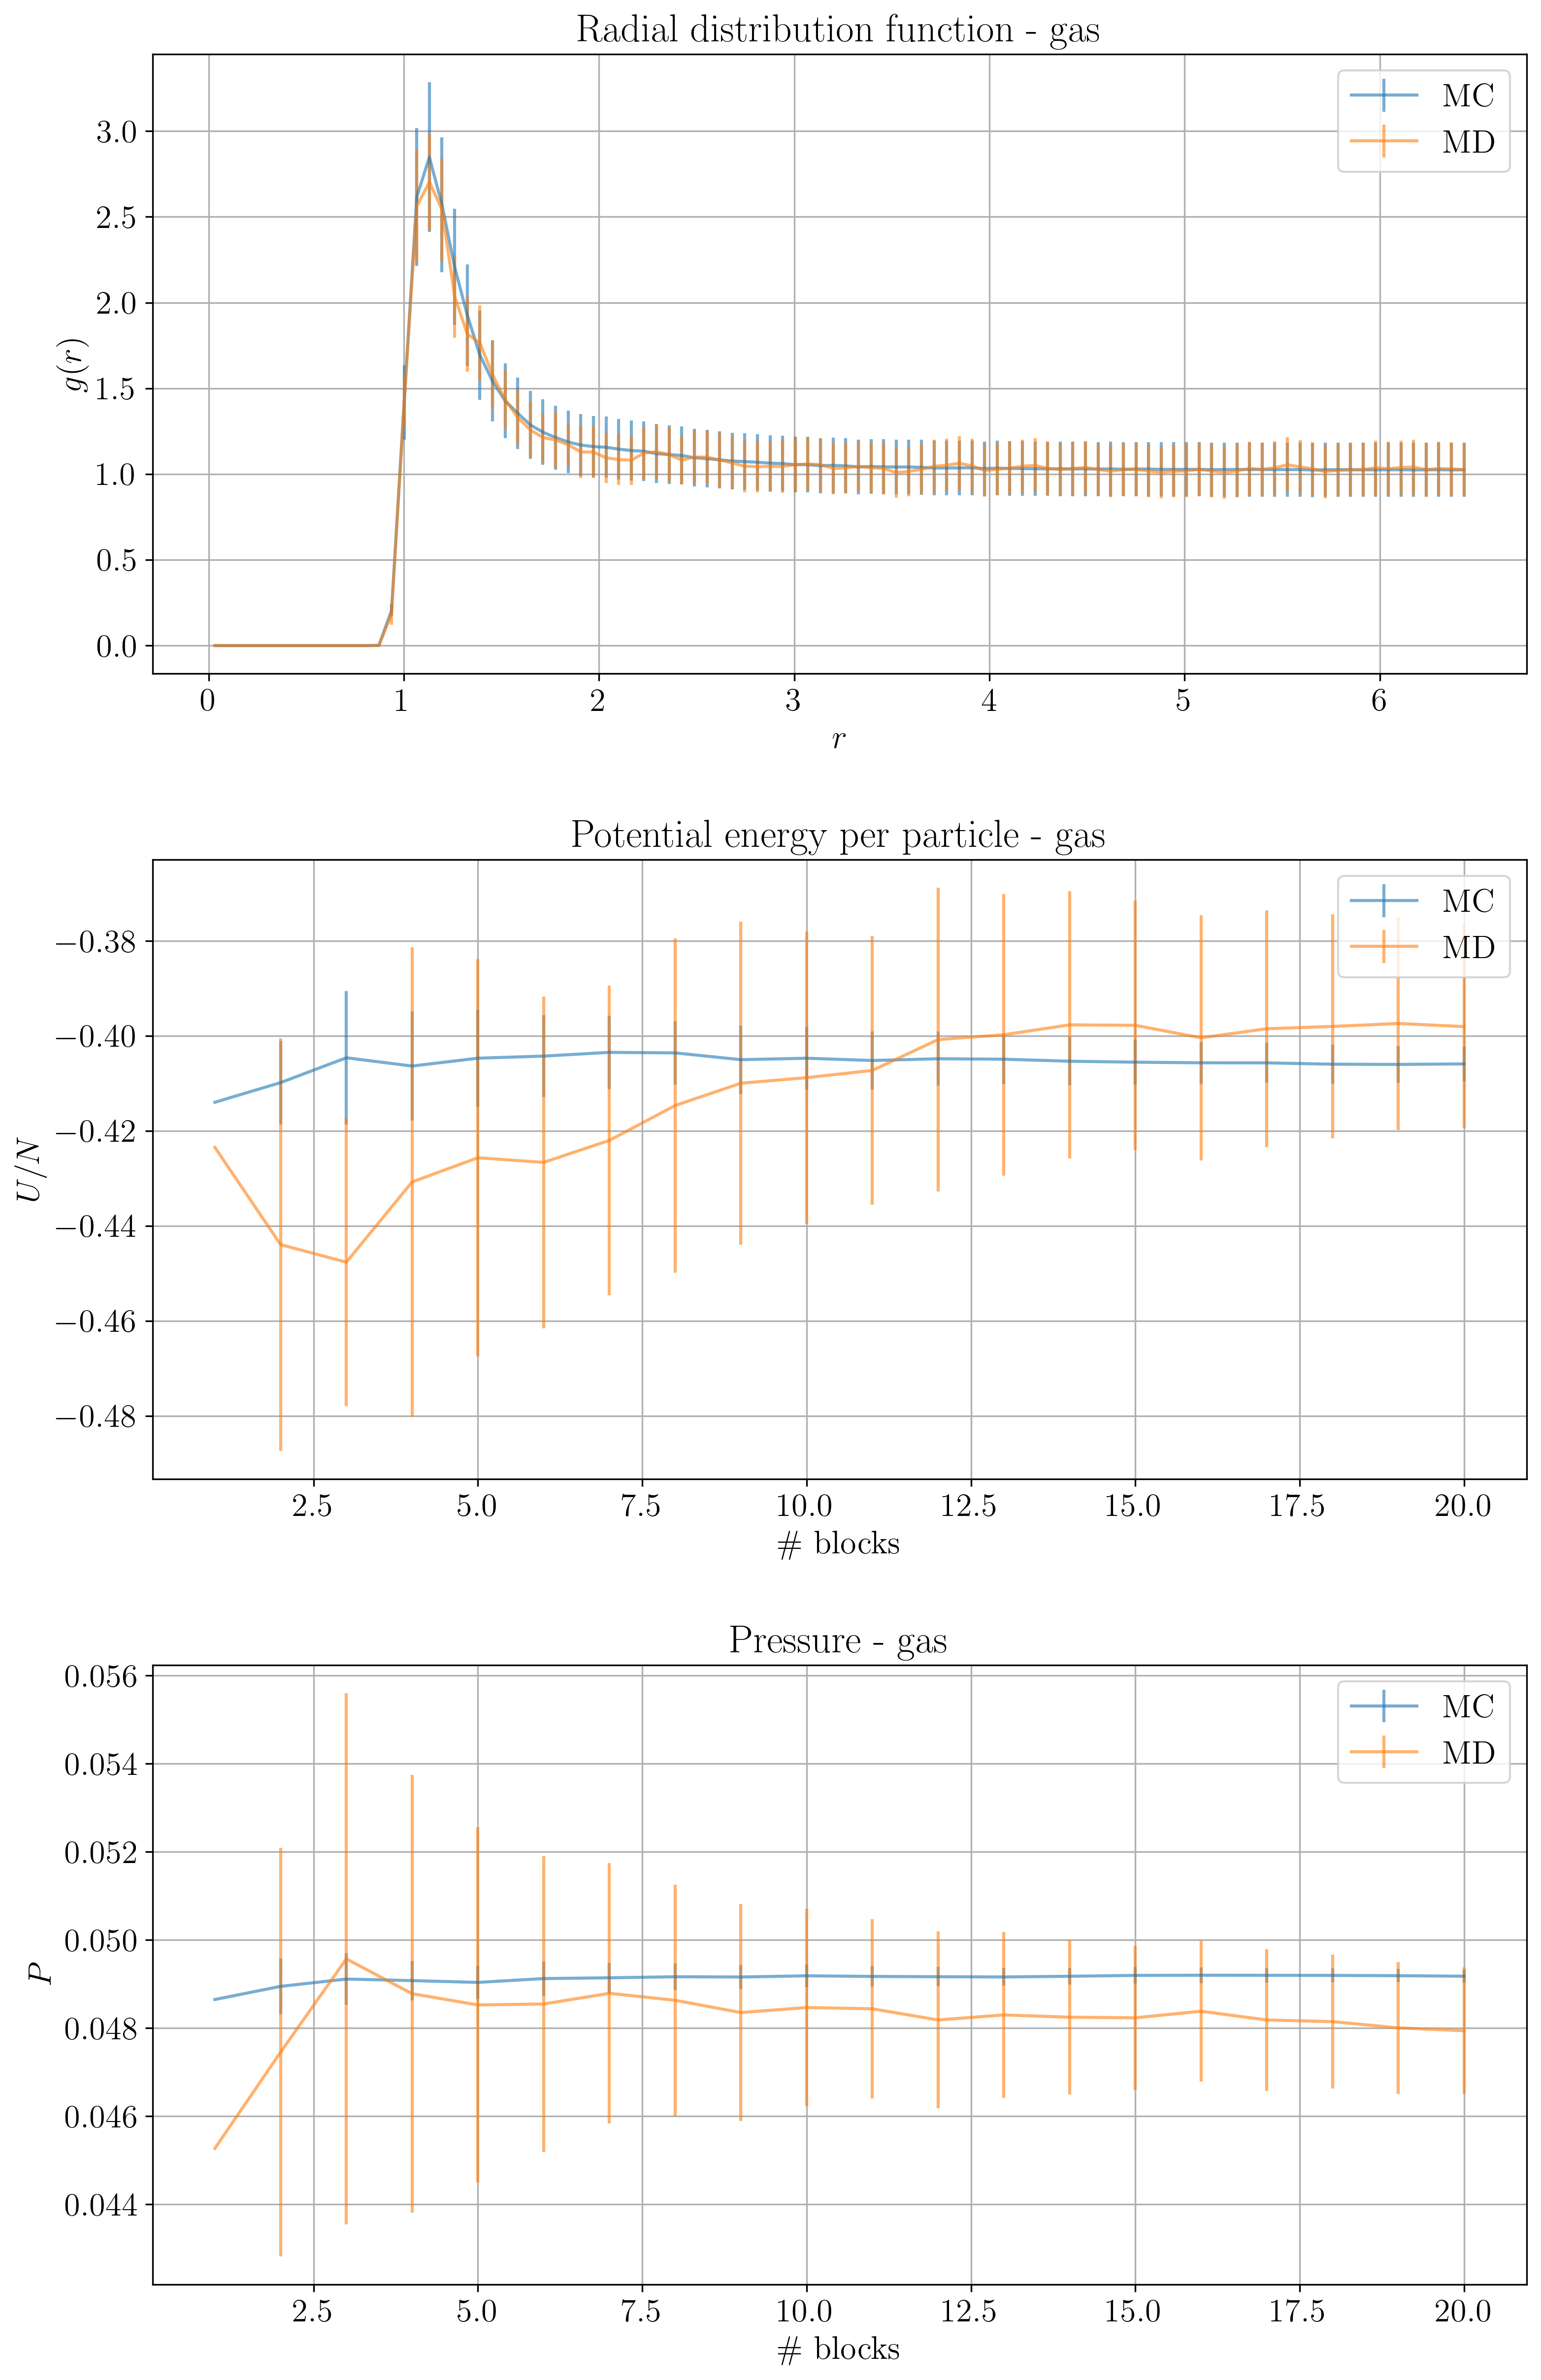

In [31]:
fig, axs = plt.subplots(3,1,figsize=(12,20), dpi=300)

r1, g1, err1 = np.loadtxt("MDNVE_MCNVT/data/MC/07.4/gas_output_final_gdir.dat", usecols=(1,3,4), unpack=True)
r2, g2, err2 = np.loadtxt("MDNVE_MCNVT/data/MD/07.4/gas_output_final_gdir.dat", usecols=(1,3,4), unpack=True)

axs[0].errorbar(r1,g1,yerr=3*err1, label="MC", alpha=0.6)
axs[0].errorbar(r2,g2,yerr=3*err2, label="MD", alpha=0.6)
axs[0].set_xlabel("$r$")
axs[0].set_ylabel("$g(r)$")
axs[0].set_title("Radial distribution function - gas")
axs[0].legend()
axs[0].grid(True)

r1, g1, err1 = np.loadtxt("MDNVE_MCNVT/data/MC/07.4/gas_output_epot.dat", usecols=(0,2,3), unpack=True)
r2, g2, err2 = np.loadtxt("MDNVE_MCNVT/data/MD/07.4/gas_output_epot.dat", usecols=(0,2,3), unpack=True)

axs[1].errorbar(r1,g1,yerr=3*err1, label="MC", alpha=0.6)
axs[1].errorbar(r2,g2,yerr=3*err2, label="MD", alpha=0.6)
axs[1].set_xlabel("\# blocks")
axs[1].set_ylabel("$U/N$")
axs[1].set_title("Potential energy per particle - gas")
axs[1].legend()
axs[1].grid(True)

r1, g1, err1 = np.loadtxt("MDNVE_MCNVT/data/MC/07.4/gas_output_pres.dat", usecols=(0,2,3), unpack=True)
r2, g2, err2 = np.loadtxt("MDNVE_MCNVT/data/MD/07.4/gas_output_pres.dat", usecols=(0,2,3), unpack=True)

axs[2].errorbar(r1,g1,yerr=3*err1, label="MC", alpha=0.6)
axs[2].errorbar(r2,g2,yerr=3*err2, label="MD", alpha=0.6)
axs[2].set_xlabel("\# blocks")
axs[2].set_ylabel("$P$")
axs[2].set_title("Pressure - gas")
axs[2].legend()
axs[2].grid(True)

plt.subplots_adjust(hspace=0.3)

plt.show()